In [3]:
import pandas as pd

from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Ridge

from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error

from sklearn.preprocessing import StandardScaler, LabelEncoder

import kagglehub

import numpy as np

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

import seaborn as sns

import time

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV, cross_val_score

In [ ]:
def load_data():

  path = kagglehub.dataset_download("tamber/steam-video-games")

  path = path + '/steam-200k.csv'

  data = pd.read_csv(path, header=None)

  data.columns = ['user_id', 'game-title', 'behavior-name', 'value', 'extra']

  path = kagglehub.dataset_download("fronkongames/steam-games-dataset")

  steam_descriptions = pd.read_json(path + '/games.json')

  steam_descriptions = steam_descriptions.T






  return data, steam_descriptions

In [5]:
data, steam_descriptions = load_data()

In [6]:
print(steam_descriptions)

                           name  release_date required_age  price dlc_count  \
20200          Galactic Bowling  Oct 21, 2008            0  19.99         0   
655370             Train Bandit  Oct 12, 2017            0   0.99         0   
1732930            Jolt Project  Nov 17, 2021            0   4.99         0   
1355720                Henosis™  Jul 23, 2020            0   5.99         0   
1139950   Two Weeks in Painland   Feb 3, 2020            0    0.0         0   
...                         ...           ...          ...    ...       ...   
3080940  Femdom Game World: Mom  Aug 22, 2024            0   4.19         0   
2593970             Blocky Farm  Aug 30, 2024            0   8.99         0   
3137150    Infiltrate & Extract  Aug 30, 2024            0    0.0         0   
3124670       Escape The Garage  Aug 29, 2024            0   4.99         0   
3054200              Lober Lobe  Aug 30, 2024            0   4.49         0   

                                      detailed_desc

# Perform EDA on data

In [7]:
def perform_EDA(data):

  # Check the first few rows

  print(data.head())



  print('----- End of data head -----')



  # Check the shape of the data

  print(data.shape)



  print('----- End of data shape -----')



  # Check the data types

  print(data.dtypes)



  print('----- End of data types -----')



  print(data.describe())



  print('----- End of describe -----')



  # Check for missing values

  print(data.isnull().sum())



  print('----- End of null -----')



  # Check for duplicates

  print(data.duplicated().sum())



  print('----- End of duplicated -----')



  # Check the unique values in each column

  print(data.nunique())



  print('----- End of unique -----')



  # Check the value counts in each column

  # print(data['behavior-name'].value_counts())

## Specific EDAs

In [ ]:
def plot_total_playtime(dataframe, label_encoder):
  data = dataframe[['game-title', 'total_playtime']].copy()

  data['game-title'] = label_encoder.inverse_transform(data['game-title'])

  sorted_df = data.sort_values(by='total_playtime', ascending=False).head(50)

  plt.figure(figsize=(10, 6))
  sns.barplot(x='total_playtime', y='game-title', data=sorted_df, palette='viridis')
  plt.title('Distribution of Total Playtime', fontsize=16)
  plt.xlabel('Total Playtime', fontsize=14)
  plt.ylabel('Frequency', fontsize=14)
  plt.grid(axis='y', linestyle='--', alpha=0.7)
  plt.show()

In [ ]:
def plot_average_playtime(dataframe, label_encoder):
    data = dataframe[['game-title', 'avg_playtime']].copy()

    data['game-title'] = label_encoder.inverse_transform(data['game-title'])

    sorted_df = data.sort_values(by='avg_playtime', ascending=False).head(50)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='avg_playtime', y='game-title', data=sorted_df, palette='viridis')
    plt.title('Top 50 Games by Average Playtime', fontsize=16)
    plt.xlabel('Average Playtime', fontsize=14)
    plt.ylabel('Game Title', fontsize=14)
    plt.tight_layout()
    plt.show()

In [10]:
def plot_avg_hours_distribution(dataframe):
    plt.figure(figsize=(10, 6))
    sns.histplot(dataframe['avg_hours_in_game'], bins=30, kde=True, color='skyblue')
    plt.title('Distribution of Average Hours in Games', fontsize=16)
    plt.xlabel('Average Hours in Game', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [11]:
def plot_purchase_vs_num_bought(dataframe):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='purchase_no_play', y='num_bought', data=dataframe, color='purple')
    plt.title('Purchases with No Play vs Total Number of Games Bought', fontsize=16)
    plt.xlabel('Number of Purchases with No Play', fontsize=14)
    plt.ylabel('Total Number of Games Bought', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

In [12]:
def plot_user_distribution(dataframe):
    plt.figure(figsize=(12, 6))
    sns.histplot(dataframe['user_id'], bins=50, kde=False, color='green')
    plt.title('Distribution of User IDs', fontsize=16)
    plt.xlabel('User ID', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [13]:
def plot_correlation_heatmap(dataframe):
    data = dataframe.drop(columns=['user_id'])
    plt.figure(figsize=(8, 6))
    correlation_matrix = data.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap', fontsize=16)
    plt.tight_layout()
    plt.show()

In [ ]:
def recommend_games(user_id, utility_matrix, predicted_ratings_df, top_n=5):
    user_interactions = utility_matrix.loc[:, user_id]

    interacted_games = user_interactions[user_interactions != -1].index

    user_predictions = predicted_ratings_df[user_id]


    # recommendations = user_predictions.drop(index=interacted_games)



    return user_predictions

In [ ]:
def perform_SVD_Calculations(data):

  utility_matrix = data.pivot_table(index='game-title', columns='user_id', values='value', fill_value=0)

  print(utility_matrix.head())


  U, S, Vt = np.linalg.svd(utility_matrix)

  Sigma = np.diag(S)



  # latent features

  k = 5



  U_k = U[:, :k]

  Sigma_k = Sigma[:k, :k]

  Vt_k = Vt[:k, :]



  gaps = np.diff(S)

  optimal_k = np.argmax(gaps) + 1 

  k = max(1, int(1.2 * optimal_k))



  print(f"Optimal k based on the gap: {optimal_k}")

  print(f"Using k = {k} after oversampling by 1.2")


  U_k = U[:, :k]

  Sigma_k = Sigma[:k, :k]

  Vt_k = Vt[:k, :]

  print("Shapes of truncated matrices:")

  print(f"U_k: {U_k.shape}")

  print(f"Sigma_k: {Sigma_k.shape}")

  print(f"Vt_k: {Vt_k.shape}")



  return U_k, Sigma_k, Vt_k, utility_matrix

In [ ]:
def calculate_SVD_Scores(data, U_k, Sigma_k, Vt_k, utility_matrix):

  predicted_ratings_matrix = np.dot(U_k, np.dot(Sigma_k, Vt_k))

  predicted_ratings_df = pd.DataFrame(predicted_ratings_matrix, index=utility_matrix.index, columns=utility_matrix.columns)

  data['svd_score'] = data.apply(lambda row: predicted_ratings_df.loc[row['game-title'], row['user_id']], axis=1)

  return data

# Create new inferred characteristics

In [ ]:
def create_inferred_charactersitics(data, steam_descriptions, seed):

  data.loc[data['behavior-name'] == 'purchase', 'value'] = 0



  data['value'] = np.log1p(data['value'])


  label_encoder = LabelEncoder()

  data['game-title'] = label_encoder.fit_transform(data['game-title'])




  data.drop(columns=['extra'], inplace=True)



  # 1. Preprocessing and Feature Engineering

  # Create user-level features

  user_features = data[data['behavior-name'] == 'play'].groupby('user_id').agg({

      'value': 'mean'

  }).rename(columns={'value': 'avg_hours_in_game'}).reset_index()



  purchase_no_play = data[data['behavior-name'] == 'purchase'].groupby('user_id').size()

  purchase_no_play = purchase_no_play.fillna(0).astype(int).reset_index()

  purchase_no_play.columns = ['user_id', 'purchase_no_play']



  user_features = user_features.merge(purchase_no_play, on='user_id')


  games_bought = data.groupby('user_id').size().reset_index(name='num_bought')



  user_features = user_features.merge(games_bought, on='user_id', how='left').fillna(0)



  # 2. Create game-level features

  # Calculate average playtime for each game

  game_features = data[data['behavior-name'] == 'play'].groupby('game-title').agg(

      avg_playtime=('value', 'mean')

  ).reset_index()



  # Calculate the number of purchases where there was no play for each game

  purchase_no_play = data[data['behavior-name'] == 'purchase'].groupby('game-title').size().reset_index(name='purchase_no_play')



  # Merge with game_features

  game_features = game_features.merge(purchase_no_play, on='game-title', how='left').fillna(0)



  # Calculate the total playtime for each game

  total_playtime = data[data['behavior-name'] == 'play'].groupby('game-title').agg(

      total_playtime=('value', 'sum')

  ).reset_index()



  # Merge total playtime with game_features

  game_features = game_features.merge(total_playtime, on='game-title', how='left').fillna(0)



  # Count the total number of players who either bought or played the game

  total_players = data.groupby('game-title').agg(

      total_players=('user_id', 'nunique')

  ).reset_index()



  game_features = game_features.merge(total_players, on='game-title', how='left').fillna(0)

  steam_descriptions_copy = None

  steam_descriptions_copy = steam_descriptions.copy()

  label_encoder = LabelEncoder()
  steam_descriptions_copy['name'] = label_encoder.fit_transform(steam_descriptions_copy['name'])

  steam_descriptions_copy = steam_descriptions_copy[['name', 'release_date', 'price', 'dlc_count',
                                                    #  'short_description',
                                          'metacritic_score', 'achievements', 'recommendations', 'positive',
                                          'negative', 'average_playtime_forever', 'average_playtime_2weeks',
                                          'median_playtime_forever', 'median_playtime_2weeks', 'peak_ccu', 'tags']]

  steam_descriptions.dropna(inplace=True)

  steam_descriptions_copy['release_date'] = pd.to_datetime(steam_descriptions_copy['release_date'], format='mixed', errors='coerce').dt.year

  game_features = game_features.merge(steam_descriptions_copy, left_on='game-title', right_on='name', how='left')

  game_features.drop(columns=['name'], inplace=True)

  tags_expanded = game_features['tags'].apply(pd.Series).fillna(0)

  game_features = pd.concat([game_features.drop('tags', axis=1), tags_expanded], axis=1)

  print(game_features.head())

  game_features = game_features.select_dtypes(include=[float, int])



  data = data.merge(user_features[['user_id', 'avg_hours_in_game', 'num_bought']], on='user_id', how='left')

  data = data.merge(game_features[['game-title', 'avg_playtime', 'total_playtime', 'total_players']], on='game-title', how='left')


  data.dropna(inplace=True)


  new_play_data = []



  play_data = data[data['behavior-name'] == 'play']

  purchase_data = data[data['behavior-name'] == 'purchase']



  while len(new_play_data) < len(purchase_data):

    random_play_index = np.random.randint(0, len(play_data))

    random_play_row = play_data.iloc[random_play_index]

    new_play_data.append(random_play_row)



  new_play_data = pd.DataFrame(new_play_data)



  data = pd.concat([data, new_play_data], ignore_index=True)

  print(data.shape)


  return game_features, user_features, data, label_encoder

In [ ]:
def perform_PCA(user_features, game_features):

    # Perform PCA on user_features

    pca = PCA(n_components=4)

    user_features_pca = pca.fit_transform(user_features)

    user_features['pca_user_1'] = user_features_pca[:, 0]
    user_features['pca_user_2'] = user_features_pca[:, 1]
    user_features['pca_user_3'] = user_features_pca[:, 2]
    user_features['pca_user_4'] = user_features_pca[:, 3]


    game_features_pca = pca.fit_transform(game_features)

    game_features['pca_game_1'] = game_features_pca[:, 0]
    game_features['pca_game_2'] = game_features_pca[:, 1]
    game_features['pca_game_3'] = game_features_pca[:, 2]
    game_features['pca_game_4'] = game_features_pca[:, 3]



    plt.figure(figsize=(25, 25))

    sns.scatterplot(x=user_features_pca[:, 0], y=user_features_pca[:, 1])

    plt.title('PCA on Users - PCs 1 and 2')

    plt.show()


    plt.figure(figsize=(25, 25))

    sns.scatterplot(x=user_features_pca[:, 0], y=user_features_pca[:, 2])

    plt.title('PCA on Users - PCs 1 and 3')

    plt.show()

    plt.figure(figsize=(25, 25))

    sns.scatterplot(x=user_features_pca[:, 0], y=user_features_pca[:, 3])

    plt.title('PCA on Users - PCs 1 and 4')

    plt.show()

    plt.figure(figsize=(25, 25))

    sns.scatterplot(x=user_features_pca[:, 1], y=user_features_pca[:, 2])

    plt.title('PCA on Users - PCs 2 and 3')

    plt.show()

    plt.figure(figsize=(25, 25))

    sns.scatterplot(x=user_features_pca[:, 1], y=user_features_pca[:, 3])

    plt.title('PCA on Users - PCs 2 and 4')

    plt.show()

    plt.figure(figsize=(25, 25))

    sns.scatterplot(x=user_features_pca[:, 2], y=user_features_pca[:, 3])

    plt.title('PCA on Users - PCs 3 and 4')

    plt.show()




    plt.figure(figsize=(25, 25))

    sns.scatterplot(x=game_features_pca[:, 0], y=game_features_pca[:, 1])

    plt.title('PCA on Games - PCs 1 and 2')

    plt.show()


    plt.figure(figsize=(25, 25))

    sns.scatterplot(x=game_features_pca[:, 0], y=game_features_pca[:, 2])

    plt.title('PCA on Games - PCs 1 and 3')

    plt.show()

    plt.figure(figsize=(25, 25))

    sns.scatterplot(x=game_features_pca[:, 0], y=game_features_pca[:, 3])

    plt.title('PCA on Games - PCs 1 and 4')

    plt.show()

    plt.figure(figsize=(25, 25))

    sns.scatterplot(x=game_features_pca[:, 1], y=game_features_pca[:, 2])

    plt.title('PCA on Games - PCs 2 and 3')

    plt.show()

    plt.figure(figsize=(25, 25))

    sns.scatterplot(x=game_features_pca[:, 1], y=game_features_pca[:, 3])

    plt.title('PCA on Games - PCs 2 and 4')

    plt.show()

    plt.figure(figsize=(25, 25))

    sns.scatterplot(x=game_features_pca[:, 2], y=game_features_pca[:, 3])

    plt.title('PCA on Games - PCs 3 and 4')

    plt.show()

    return user_features, game_features

In [ ]:
def perform_KMeans(user_features, game_features, seed, user_clusters=10, game_clusters=10):
    user_pca_columns = ['pca_user_1', 'pca_user_2', 'pca_user_3', 'pca_user_4']
    game_pca_columns = ['pca_game_1', 'pca_game_2', 'pca_game_3', 'pca_game_4']

    kmeans_user = KMeans(n_clusters=user_clusters, random_state=seed)
    user_features['user_cluster'] = kmeans_user.fit_predict(user_features)

    kmeans_game = KMeans(n_clusters=game_clusters, random_state=seed)
    game_features['game_cluster'] = kmeans_game.fit_predict(game_features)

    print("User Features with Clusters:")
    print(user_features.head())

    print("\nGame Features with Clusters:")
    print(game_features.head())

    plt.figure(figsize=(25, 25))
    sns.scatterplot(x=user_features['pca_user_1'], y=user_features['pca_user_2'], hue=user_features['user_cluster'], palette='viridis')
    plt.title('User Clusters')
    plt.show()

    plt.figure(figsize=(25, 25))
    sns.scatterplot(x=game_features['pca_game_1'], y=game_features['pca_game_2'], hue=game_features['game_cluster'], palette='viridis')
    plt.title('Game Clusters')
    plt.show()

    return user_features, game_features

In [20]:
def regression_model(data, seed):

  # Build a regression model to predict playtime using data dataframe

  X = data[data.columns.values]

  X.columns = X.columns.astype(str)

  y = data['value']



  # Trying log transformation on the target variable to address skewness

  y = np.log1p(data['value'])



  # Train-test split

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)



  # --------------  LINEAR REGRESSION ---------------------

  # model = LinearRegression()

  # model.fit(X_train, y_train)



  # y_pred = model.predict(X_train)



  # rmse = mean_squared_error(y_train, y_pred)

  # mae = mean_absolute_error(y_train, y_pred)



  # print(f"Root Mean Squared Error (Train): {rmse}")

  # print(f"Mean Absolute Error (Train): {mae}")



  # y_pred = model.predict(X_test)



  # rmse = root_mean_squared_error(y_test, y_pred)

  # mae = mean_absolute_error(y_test, y_pred)



  # print(f"Root Mean Squared Error (Test): {rmse}")

  # print(f"Mean Absolute Error (Test): {mae}")



  # --------------------------------------



  # # Use RandomForestRegressor with GridSearchCV for hyperparameter tuning

  # rf = RandomForestRegressor(random_state=seed)

  # # param_grid = {

  # #     'n_estimators': [50, 100, 200],

  # #     'max_depth': [None, 10, 20, 30],

  # #     'min_samples_split': [2, 5, 10],

  # #     'n_jobs': [-1]

  # # }

  # # grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error')

  # # grid_search.fit(X_train, y_train)



  # rf.fit(X_train, y_train)



  # # Best model evaluation

  # # best_rf = grid_search.best_estimator_

  # y_pred_log = rf.predict(X_test)

  # y_pred = np.expm1(y_pred_log)  # Reverse log transformation



  # # print(grid_search.best_params_)



  # # Calculate error metrics

  # mse = mean_squared_error(np.expm1(y_test), y_pred)

  # mae = mean_absolute_error(np.expm1(y_test), y_pred)



  # print(f"Improved Mean Squared Error: {mse}")

  # print(f"Mean Absolute Error: {mae}")



  # ---------------------------------------



  # -------------- RIDGE MODEL ------------



  ridge_model = Ridge(alpha=1.0)

  ridge_model.fit(X, y)



  y_pred = ridge_model.predict(X_train)



  rmse = mean_squared_error(y_train, y_pred)

  mae = mean_absolute_error(y_train, y_pred)



  print(f"Root Mean Squared Error (Train): {rmse}")

  print(f"Mean Absolute Error (Train): {mae}")

  y_pred = ridge_model.predict(X_test)

  rmse = mean_squared_error(y_test, y_pred)

  mae = mean_absolute_error(y_test, y_pred)



  print(f"Root Mean Squared Error (Test): {rmse}")

  print(f"Mean Absolute Error (Test): {mae}")



  # ----------------------------------------



  return ridge_model

In [ ]:
def random_testing(data, model, game_features):

  # Randomly pick a user-game instance from data

  random_user = data.sample(1)

  # Extract the game title for this user-game instance

  game_title = random_user['game-title'].values[0]

  # Get the average playtime for the game

  game_avg_playtime = game_features[game_features['game-title'] == game_title]['avg_playtime'].values[0]



  # # normalise the game_avg_playtime

  game_avg_playtime = (game_avg_playtime - game_features['avg_playtime'].mean()) / game_features['avg_playtime'].std()


  random_user.columns = random_user.columns.astype(str)
  # Predict playtime for the random user-game instance

  predicted_val = np.expm1(model.predict(random_user[random_user.columns.values]))



  # Recommend only if predicted playtime is greater than the game's average playtime

  if predicted_val[0] >= game_avg_playtime:

      recommendation = "Recommend"

  else:

      recommendation = "Do not recommend"



  print(f"Game Title: {game_title}")

  print(f"Predicted Playtime: {predicted_val[0]:.2f} hours")

  print(f"Actual Playtime: {random_user['value'].values[0]}")

  print(f"Average Playtime for '{game_title}': {game_avg_playtime:.2f} hours")

  print(f"Recommendation: {recommendation}")

In [22]:
def normalise_data(data):

  for col in data.columns:

    if (data.dtypes[col] == 'float64' or data.dtypes[col] == 'int64') and (col != 'game-title' and col != 'user_id')  :

      data[col] = (data[col] - data[col].mean()) / data[col].std()

  return data

In [23]:
data_original, steam_descriptions_original = load_data()

In [24]:
data = None
steam_descriptions = None

data = data_original.copy()
steam_descriptions = steam_descriptions_original.copy()

seed = int(time.time())

# U_k, Sigma_k, Vt_k, utility_matrix = perform_SVD_Calculations(data)

# data = calculate_SVD_Scores(data, U_k, Sigma_k, Vt_k, utility_matrix)

game_features, user_features, data, label_encoder = create_inferred_charactersitics(data, steam_descriptions, seed)

   game-title  avg_playtime  purchase_no_play  total_playtime  total_players  \
0           0      0.530628                 1        0.530628              1   
1           0      0.530628                 1        0.530628              1   
2           0      0.530628                 1        0.530628              1   
3           0      0.530628                 1        0.530628              1   
4           0      0.530628                 1        0.530628              1   

   release_date price dlc_count metacritic_score achievements  ... Bikes  \
0          2016   0.0         0                0            0  ...   0.0   
1          2019  6.99         0                0            0  ...   0.0   
2          2020   0.0         0                0            0  ...   0.0   
3          2019   0.0         0                0           20  ...   0.0   
4          2020   0.0         0                0            0  ...   0.0   

  Cycling Dungeons & Dragons Skiing Werewolves Faith  \
0     

In [25]:
perform_EDA(game_features)

perform_EDA(user_features)

   game-title  avg_playtime  purchase_no_play  total_playtime  total_players  \
0           0      0.530628                 1        0.530628              1   
1           0      0.530628                 1        0.530628              1   
2           0      0.530628                 1        0.530628              1   
3           0      0.530628                 1        0.530628              1   
4           0      0.530628                 1        0.530628              1   

   release_date  Early Access  Action  RPG  JRPG  ...  Bikes  Cycling  \
0          2016           0.0     0.0  0.0   0.0  ...    0.0      0.0   
1          2019           0.0     0.0  0.0   0.0  ...    0.0      0.0   
2          2020           0.0     0.0  0.0   0.0  ...    0.0      0.0   
3          2019           0.0     0.0  0.0   0.0  ...    0.0      0.0   
4          2020           0.0     0.0  0.0   0.0  ...    0.0      0.0   

   Dungeons & Dragons  Skiing  Werewolves  Faith  \
0                 0.0     0.

<ipython-input-8-c6e2e92d935c>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='total_playtime', y='game-title', data=sorted_df, palette='viridis')
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12524 (\N{KATAKANA LETTER RE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12472 (\N{KATAKANA LETTER ZI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12455 (\N{KATAKANA LETTER SMALL E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}

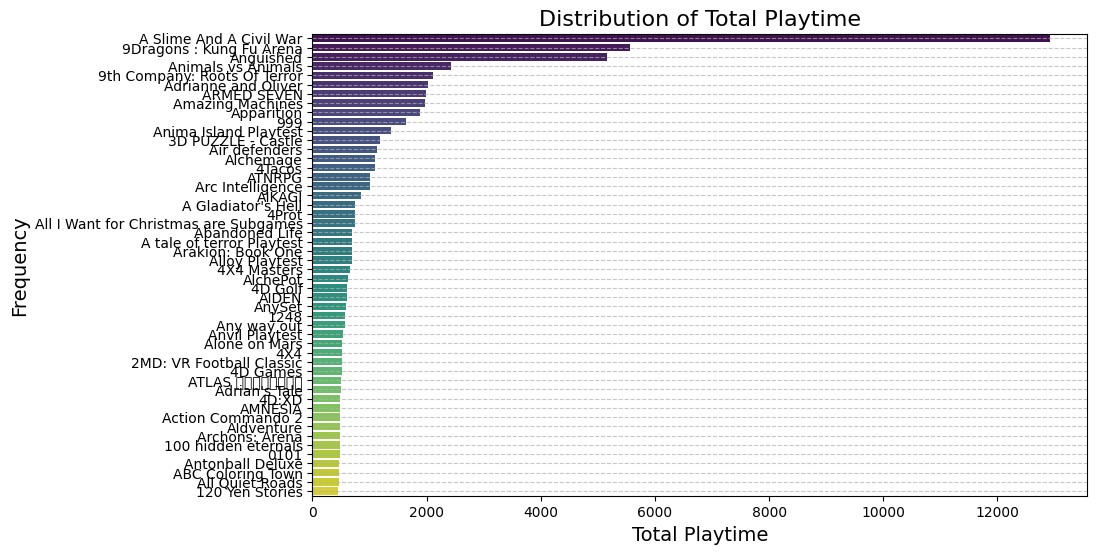

<ipython-input-9-c57a5a31e57f>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='avg_playtime', y='game-title', data=sorted_df, palette='viridis')
<ipython-input-9-c57a5a31e57f>:16: UserWarning: Glyph 12450 (\N{KATAKANA LETTER A}) missing from current font.
  plt.tight_layout()
<ipython-input-9-c57a5a31e57f>:16: UserWarning: Glyph 12459 (\N{KATAKANA LETTER KA}) missing from current font.
  plt.tight_layout()
<ipython-input-9-c57a5a31e57f>:16: UserWarning: Glyph 12487 (\N{KATAKANA LETTER DE}) missing from current font.
  plt.tight_layout()
<ipython-input-9-c57a5a31e57f>:16: UserWarning: Glyph 12511 (\N{KATAKANA LETTER MI}) missing from current font.
  plt.tight_layout()
<ipython-input-9-c57a5a31e57f>:16: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from current font.
  plt.tight_layout()
<ipython-input-

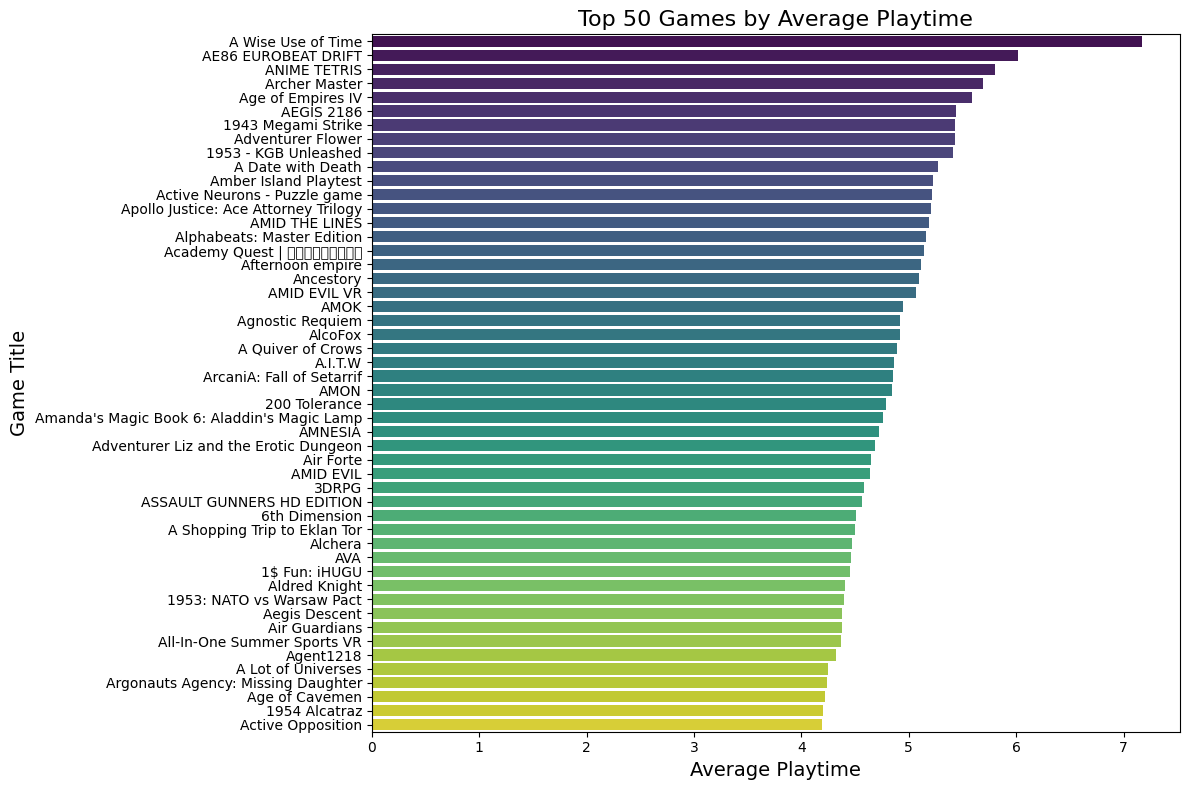

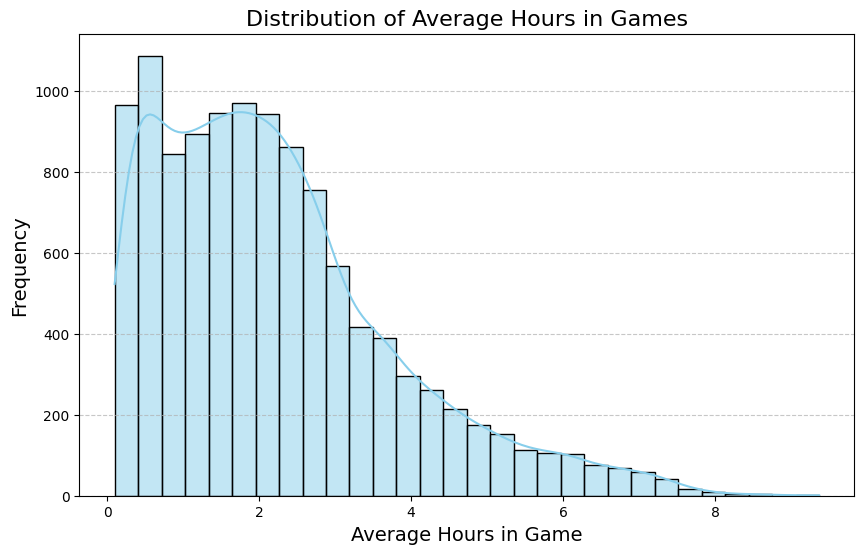

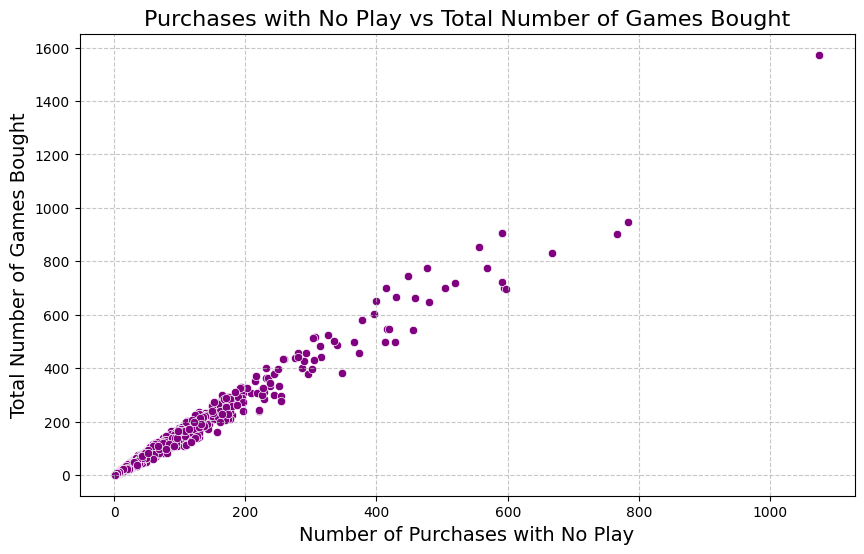

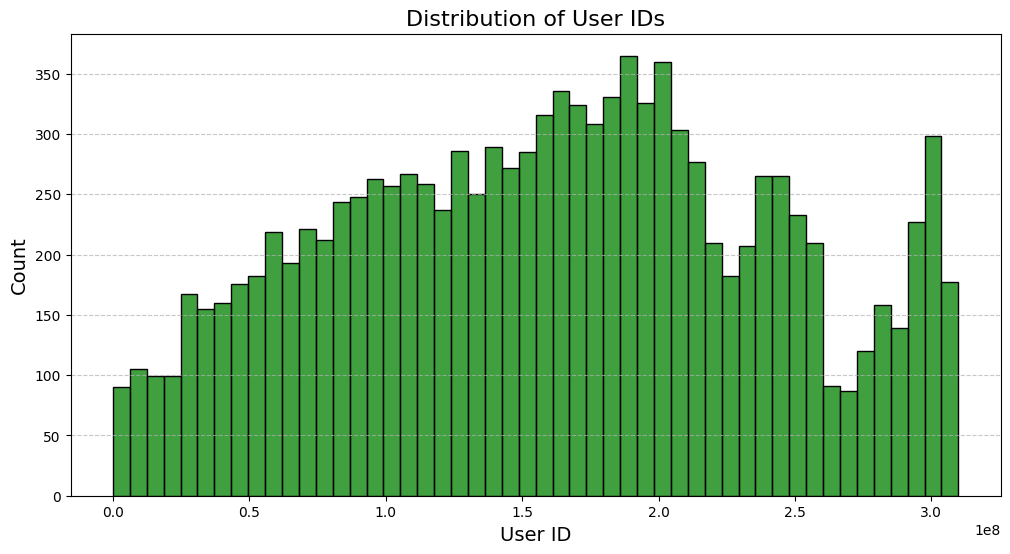

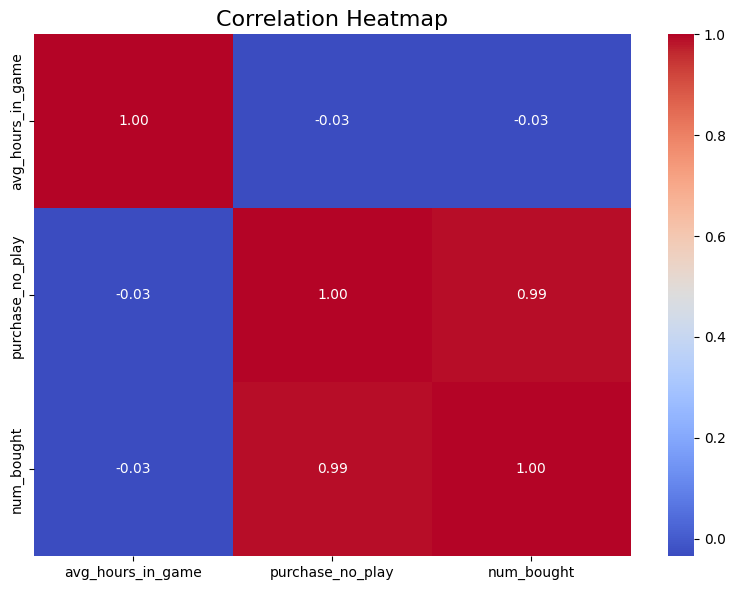

In [26]:
plot_total_playtime(game_features, label_encoder)
plot_average_playtime(game_features, label_encoder)
plot_avg_hours_distribution(user_features)
plot_purchase_vs_num_bought(user_features)
plot_user_distribution(user_features)
plot_correlation_heatmap(user_features)

In [27]:
perform_EDA(user_features)

   user_id  avg_hours_in_game  purchase_no_play  num_bought
0     5250           2.390992                21          27
1    76767           2.830461                36          56
2    86540           1.670212                82          97
3   144736           0.095310                 8           9
4   181212           0.683046                12          14
----- End of data head -----
(11350, 4)
----- End of data shape -----
user_id                int64
avg_hours_in_game    float64
purchase_no_play       int64
num_bought             int64
dtype: object
----- End of data types -----
            user_id  avg_hours_in_game  purchase_no_play    num_bought
count  1.135000e+04       11350.000000      11350.000000  11350.000000
mean   1.608620e+08           2.215617         11.180529     17.391013
std    7.847351e+07           1.584924         37.369485     54.022510
min    5.250000e+03           0.095310          1.000000      2.000000
25%    9.925787e+07           0.993252          1.00000

In [28]:
data = normalise_data(data)
game_features = normalise_data(game_features)
user_features = normalise_data(user_features)

# plot_total_playtime(game_features, label_encoder)
# plot_average_playtime(game_features, label_encoder)
# plot_avg_hours_distribution(user_features)
# plot_purchase_vs_num_bought(user_features)
# plot_user_distribution(user_features)
# plot_correlation_heatmap(user_features)

In [29]:
perform_EDA(user_features)
perform_EDA(user_features)

   user_id  avg_hours_in_game  purchase_no_play  num_bought
0     5250           0.110652          0.262767    0.177870
1    76767           0.387933          0.664164    0.714683
2    86540          -0.344121          1.895115    1.473626
3   144736          -1.337798         -0.085110   -0.155324
4   181212          -0.966969          0.021929   -0.062770
----- End of data head -----
(11350, 4)
----- End of data shape -----
user_id                int64
avg_hours_in_game    float64
purchase_no_play     float64
num_bought           float64
dtype: object
----- End of data types -----
            user_id  avg_hours_in_game  purchase_no_play    num_bought
count  1.135000e+04       1.135000e+04      1.135000e+04  1.135000e+04
mean   1.608620e+08       3.004938e-17      1.001646e-17  1.001646e-17
std    7.847351e+07       1.000000e+00      1.000000e+00  1.000000e+00
min    5.250000e+03      -1.337798e+00     -2.724289e-01 -2.849000e-01
25%    9.925787e+07      -7.712456e-01     -2.724289e-0

<ipython-input-18-159cd625603e>:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  game_features['pca_game_1'] = game_features_pca[:, 0]
<ipython-input-18-159cd625603e>:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  game_features['pca_game_2'] = game_features_pca[:, 1]
<ipython-input-18-159cd625603e>:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a 

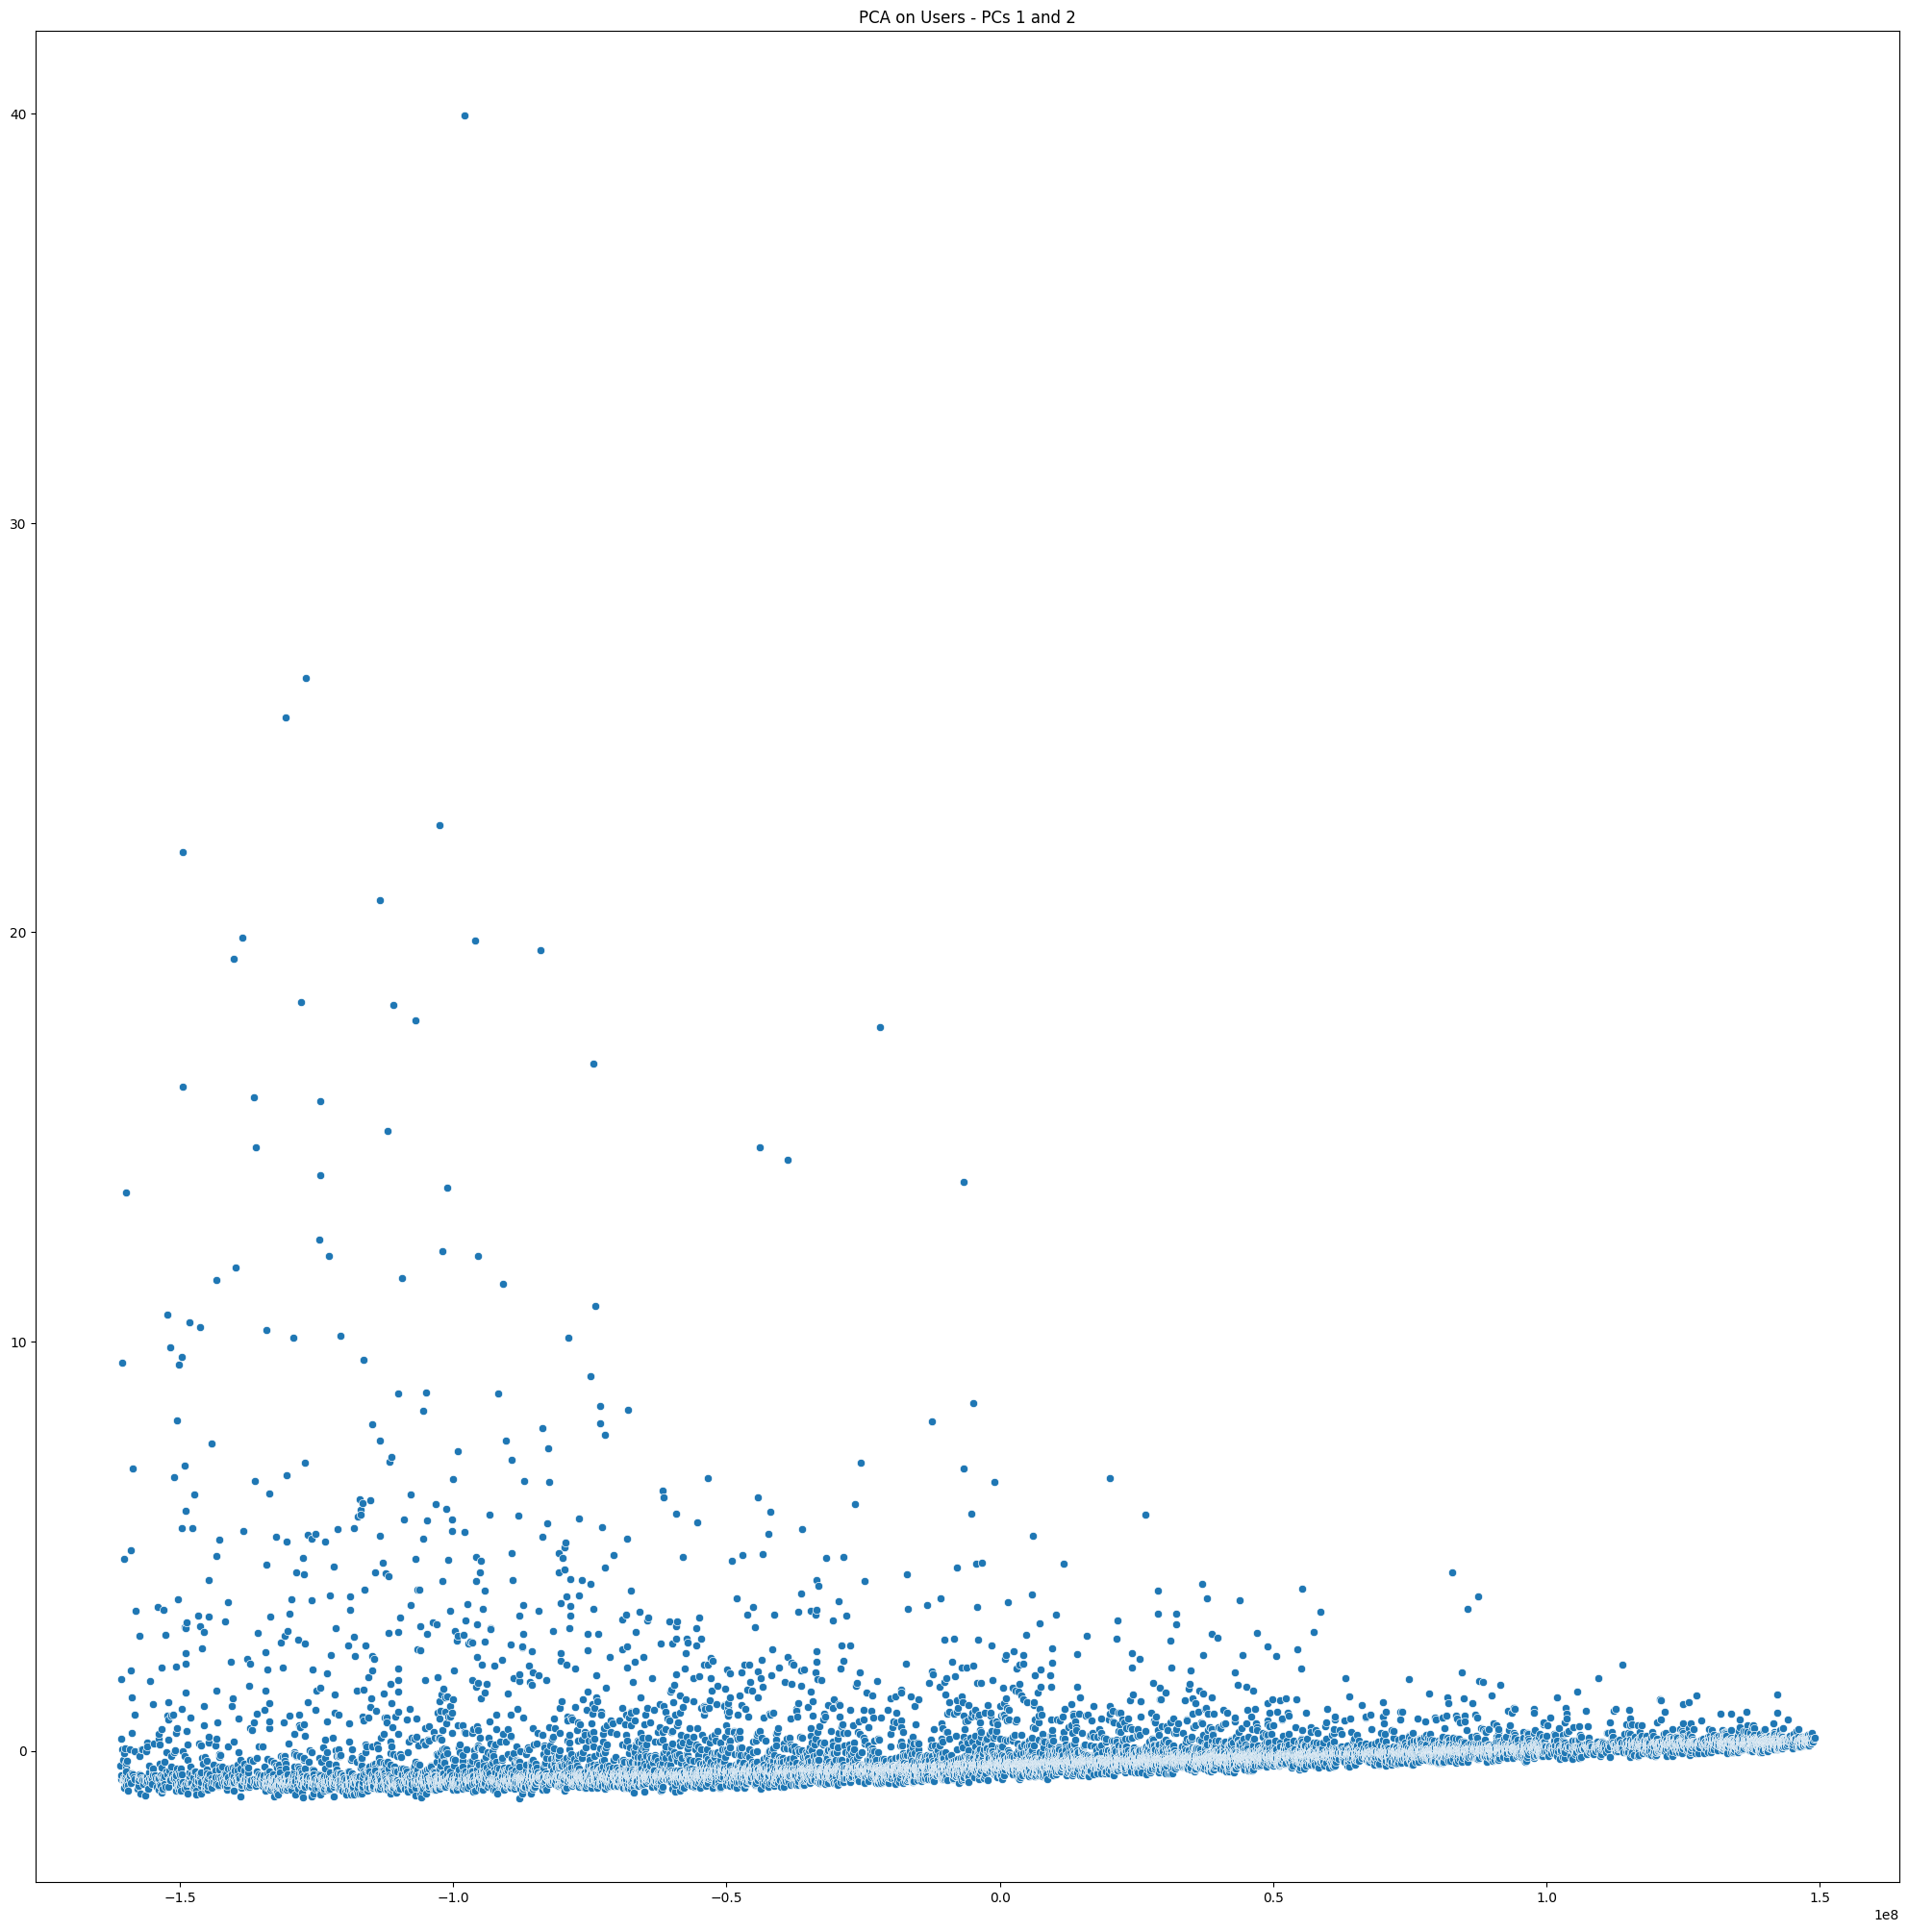

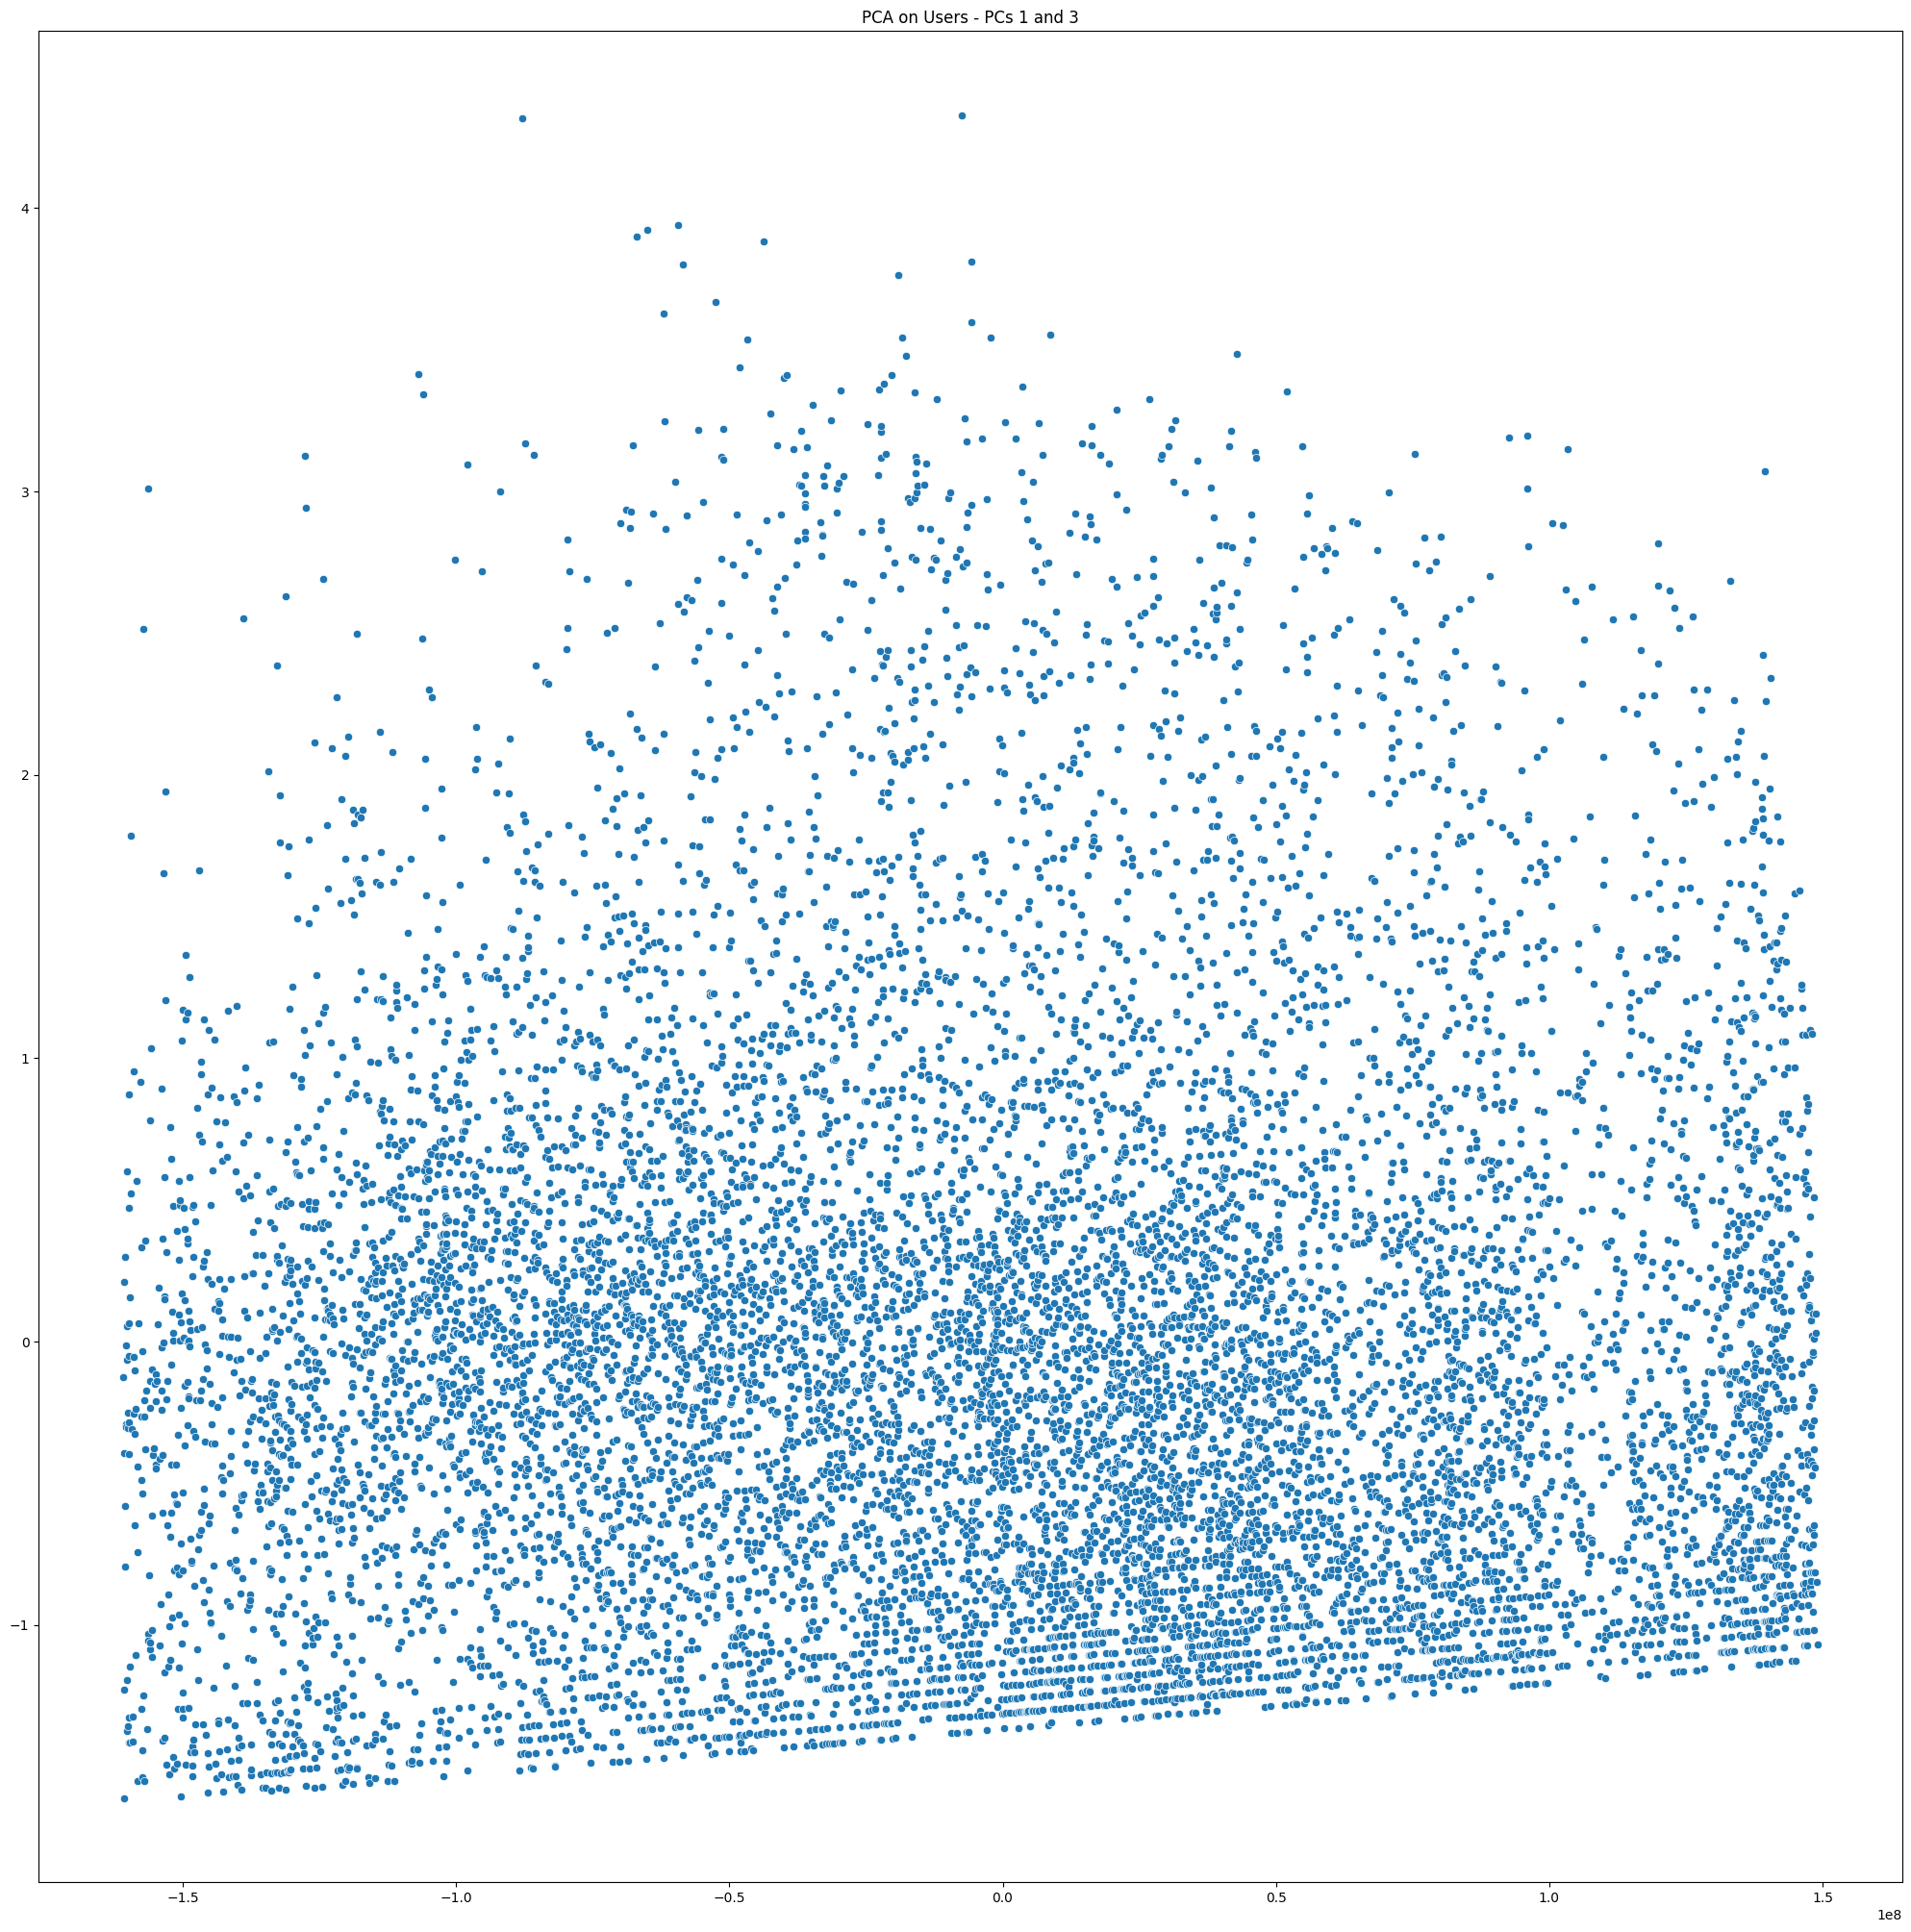

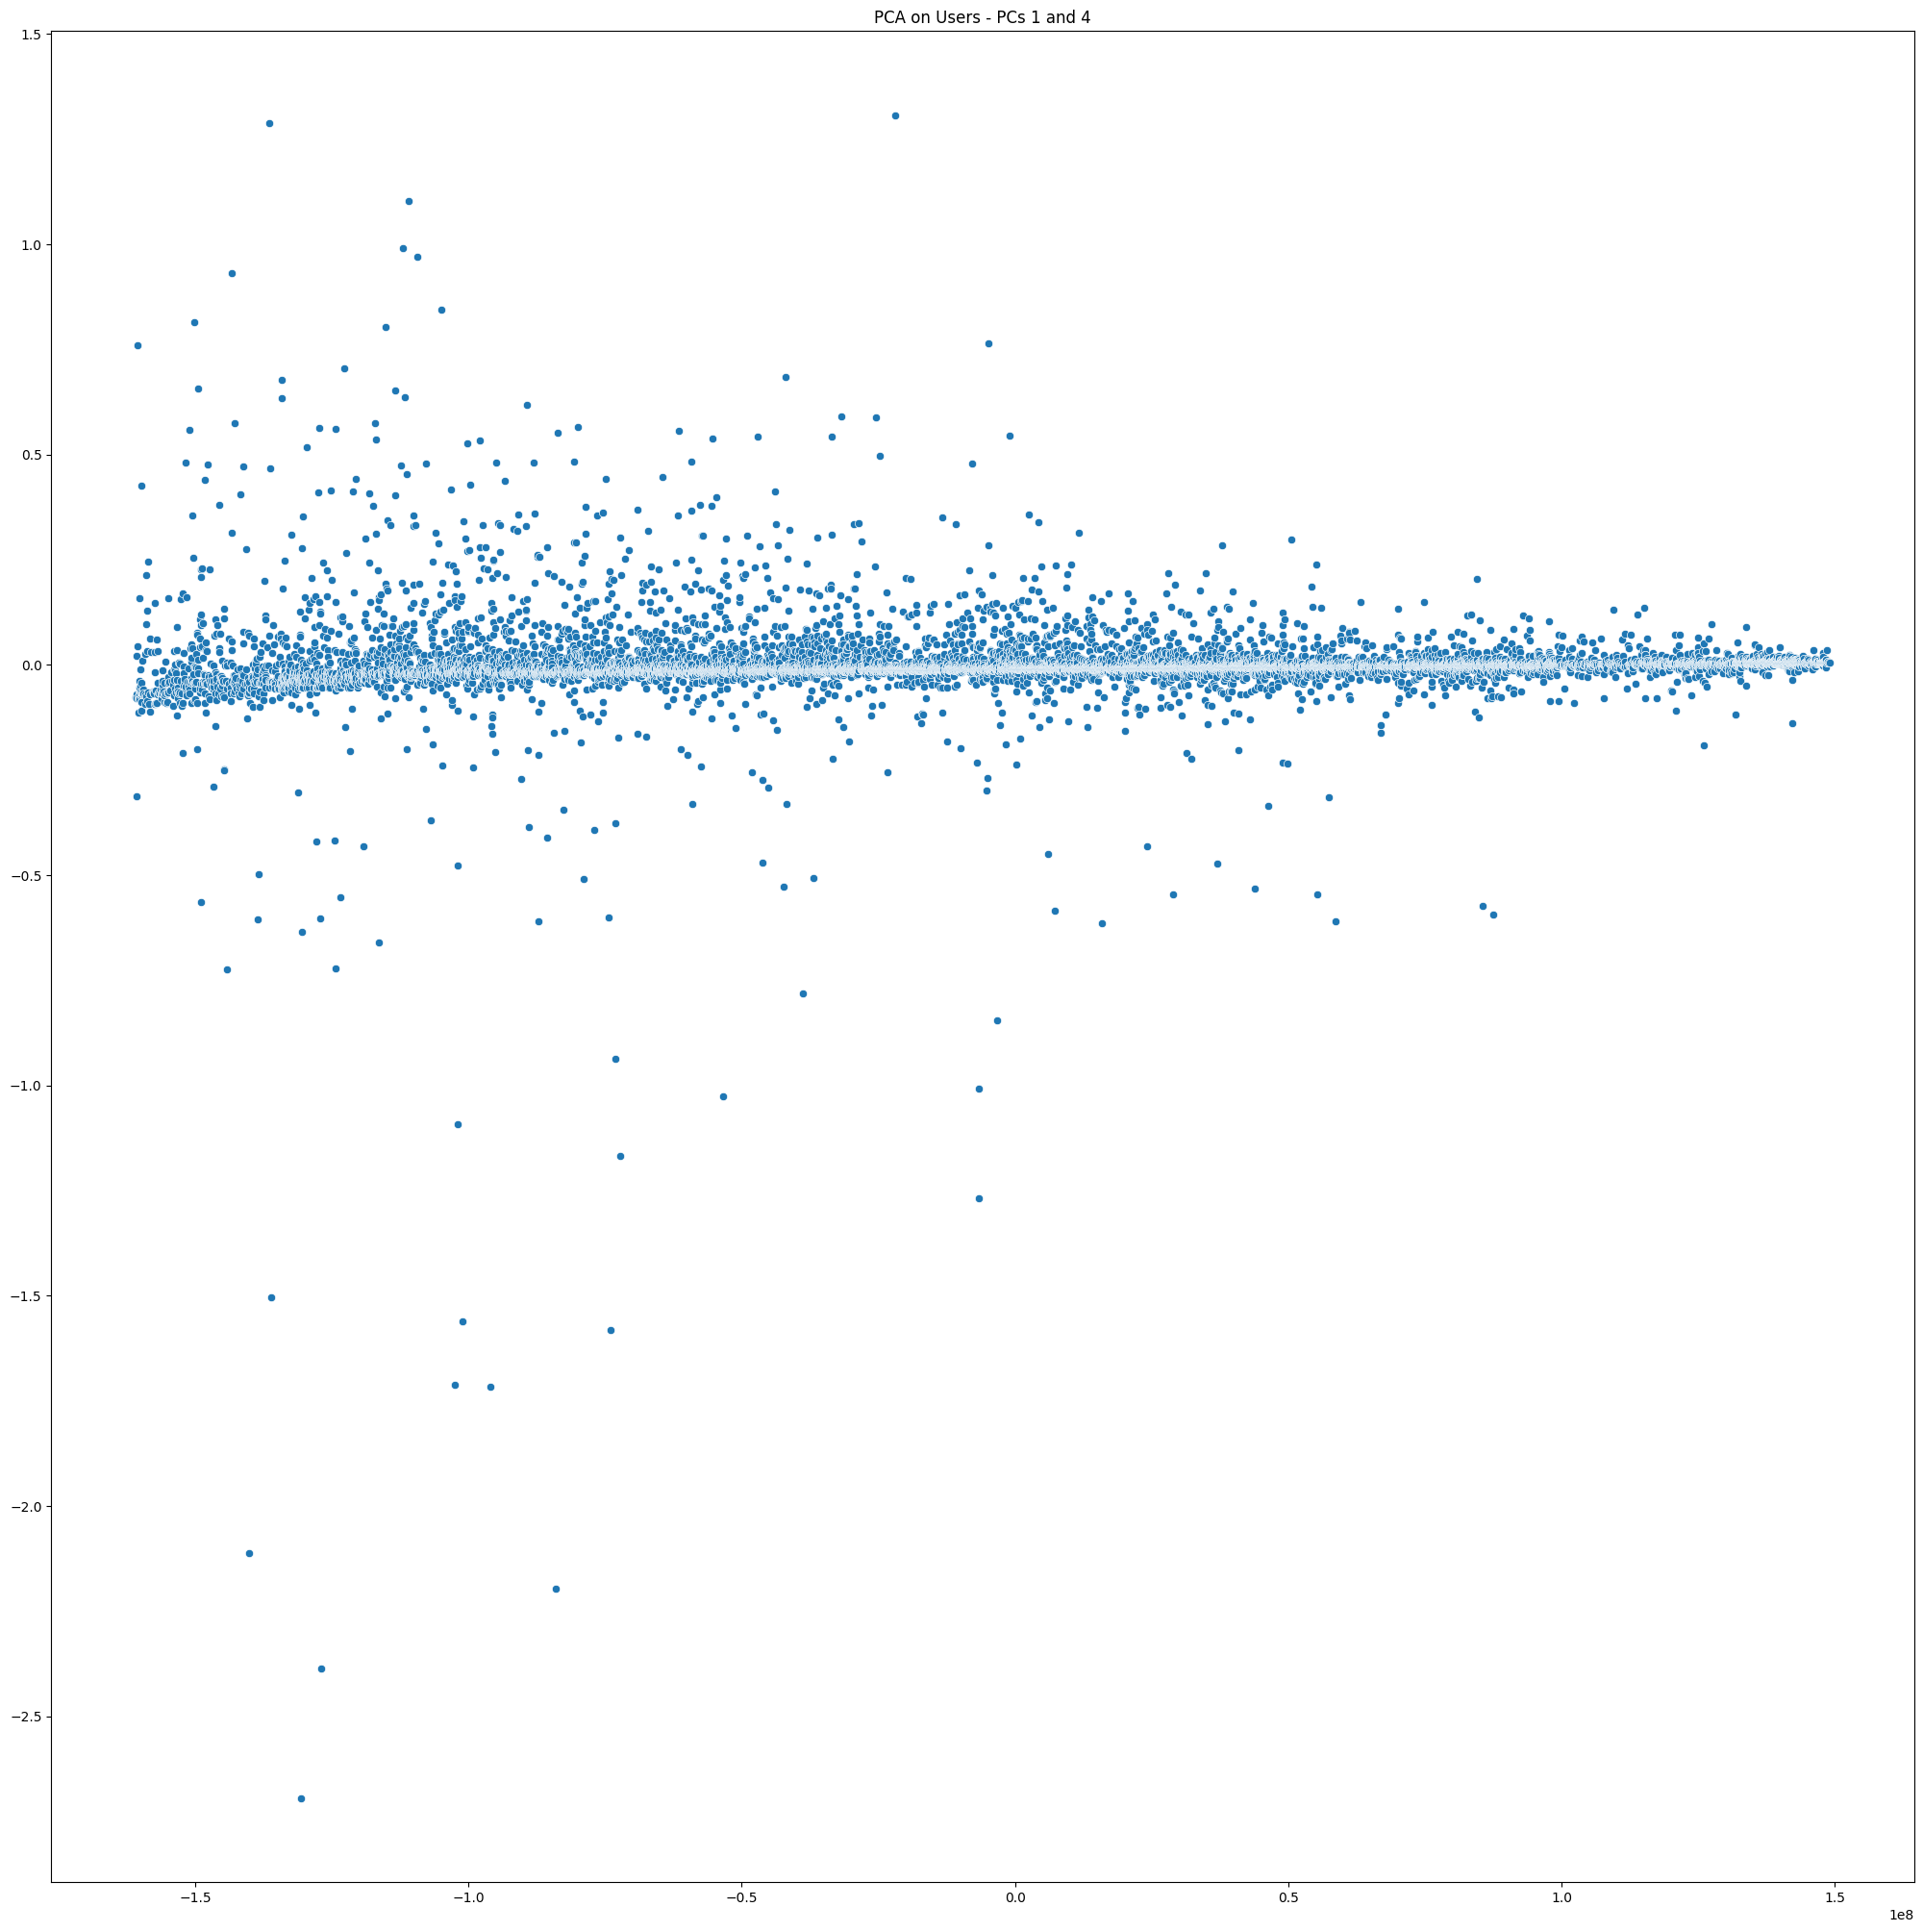

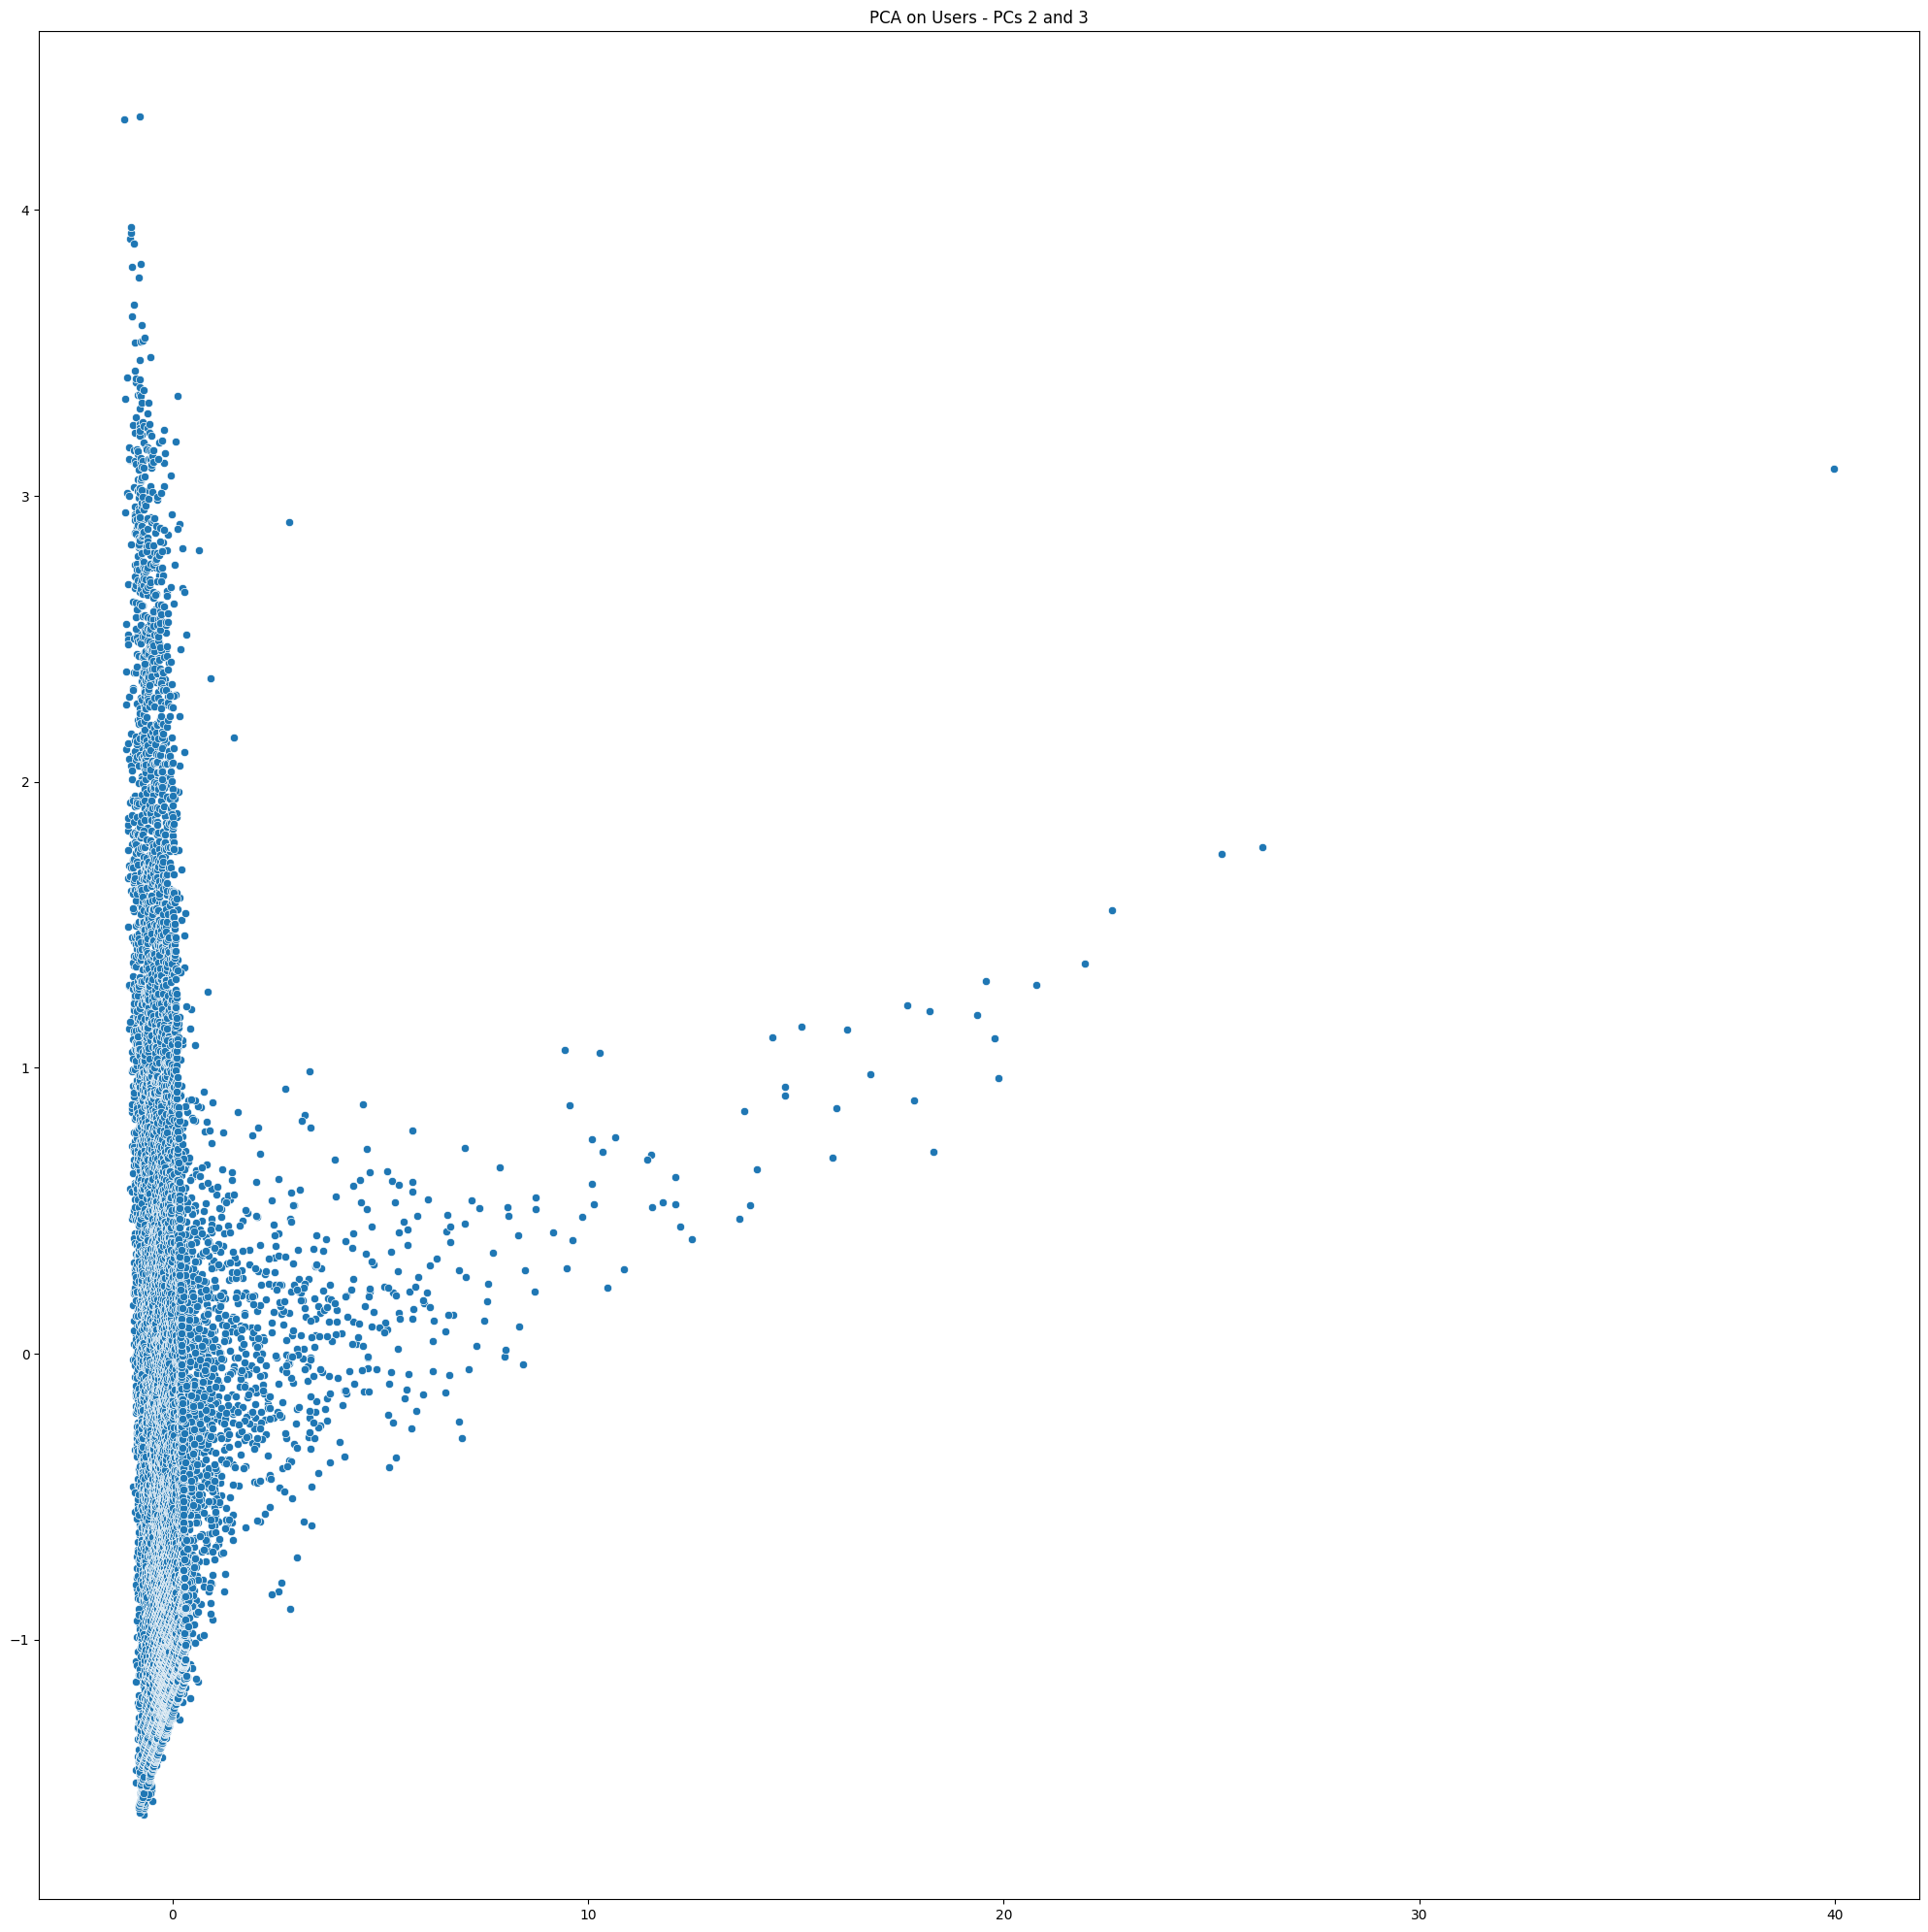

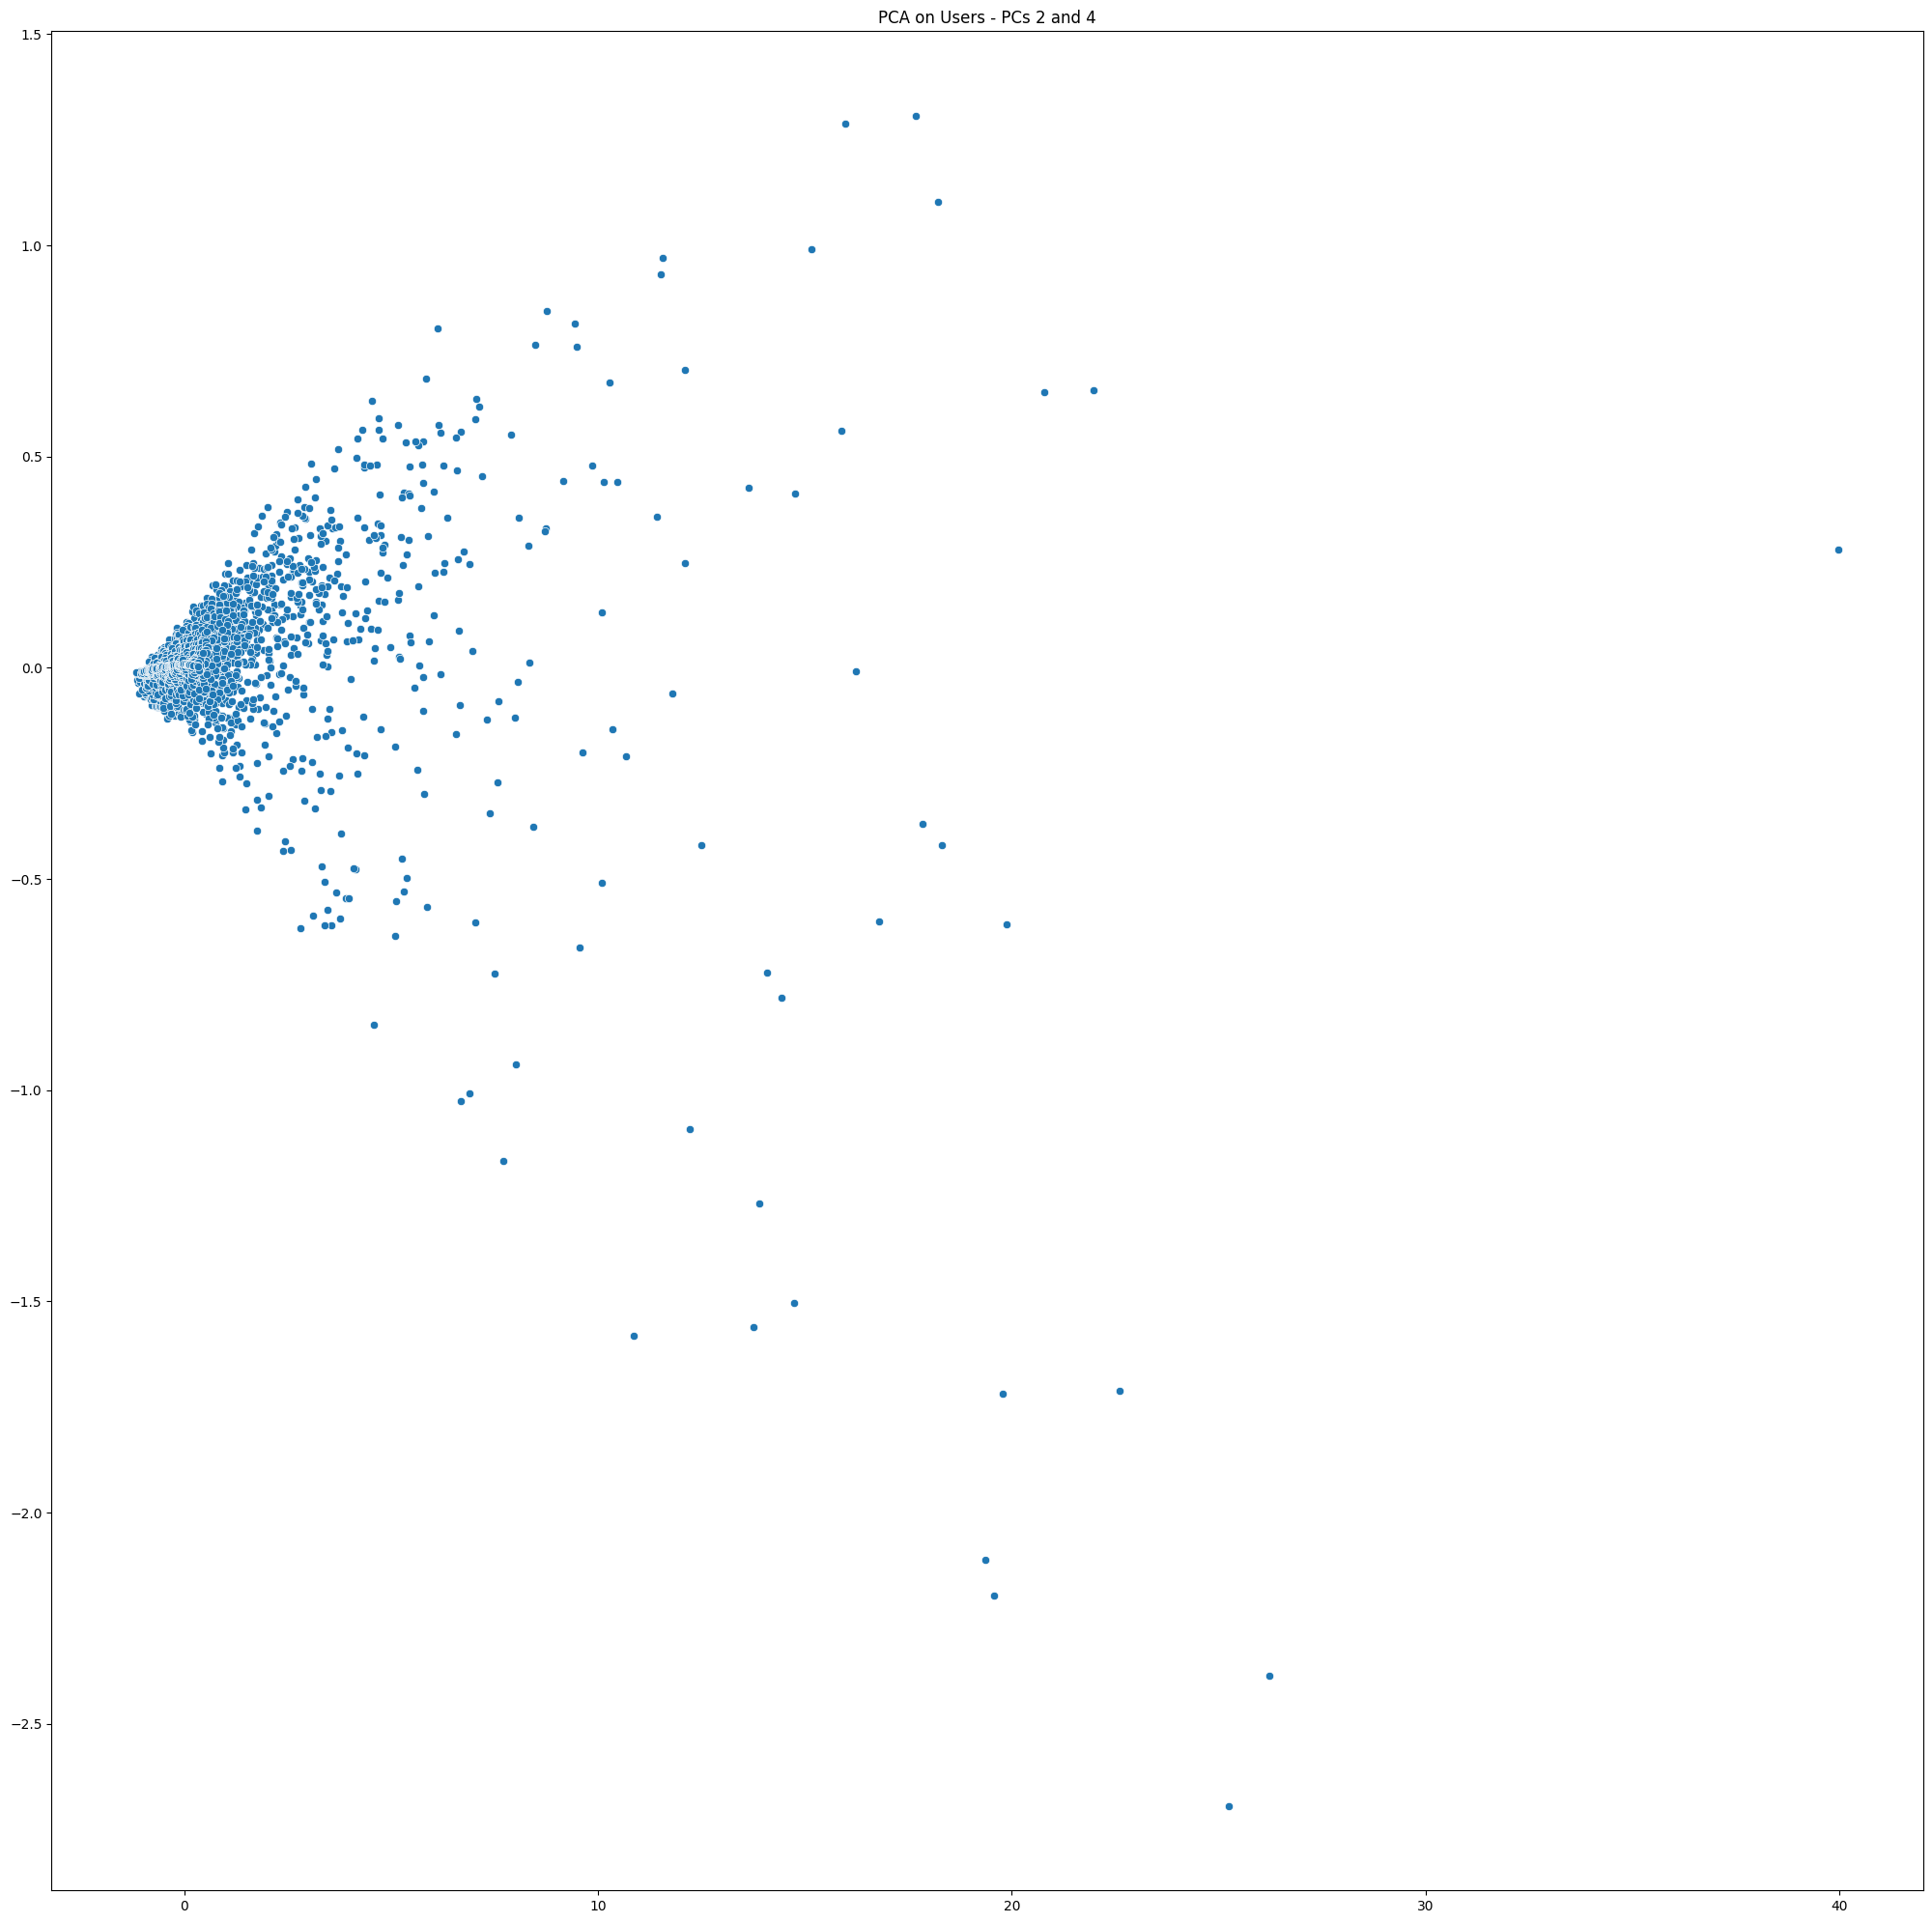

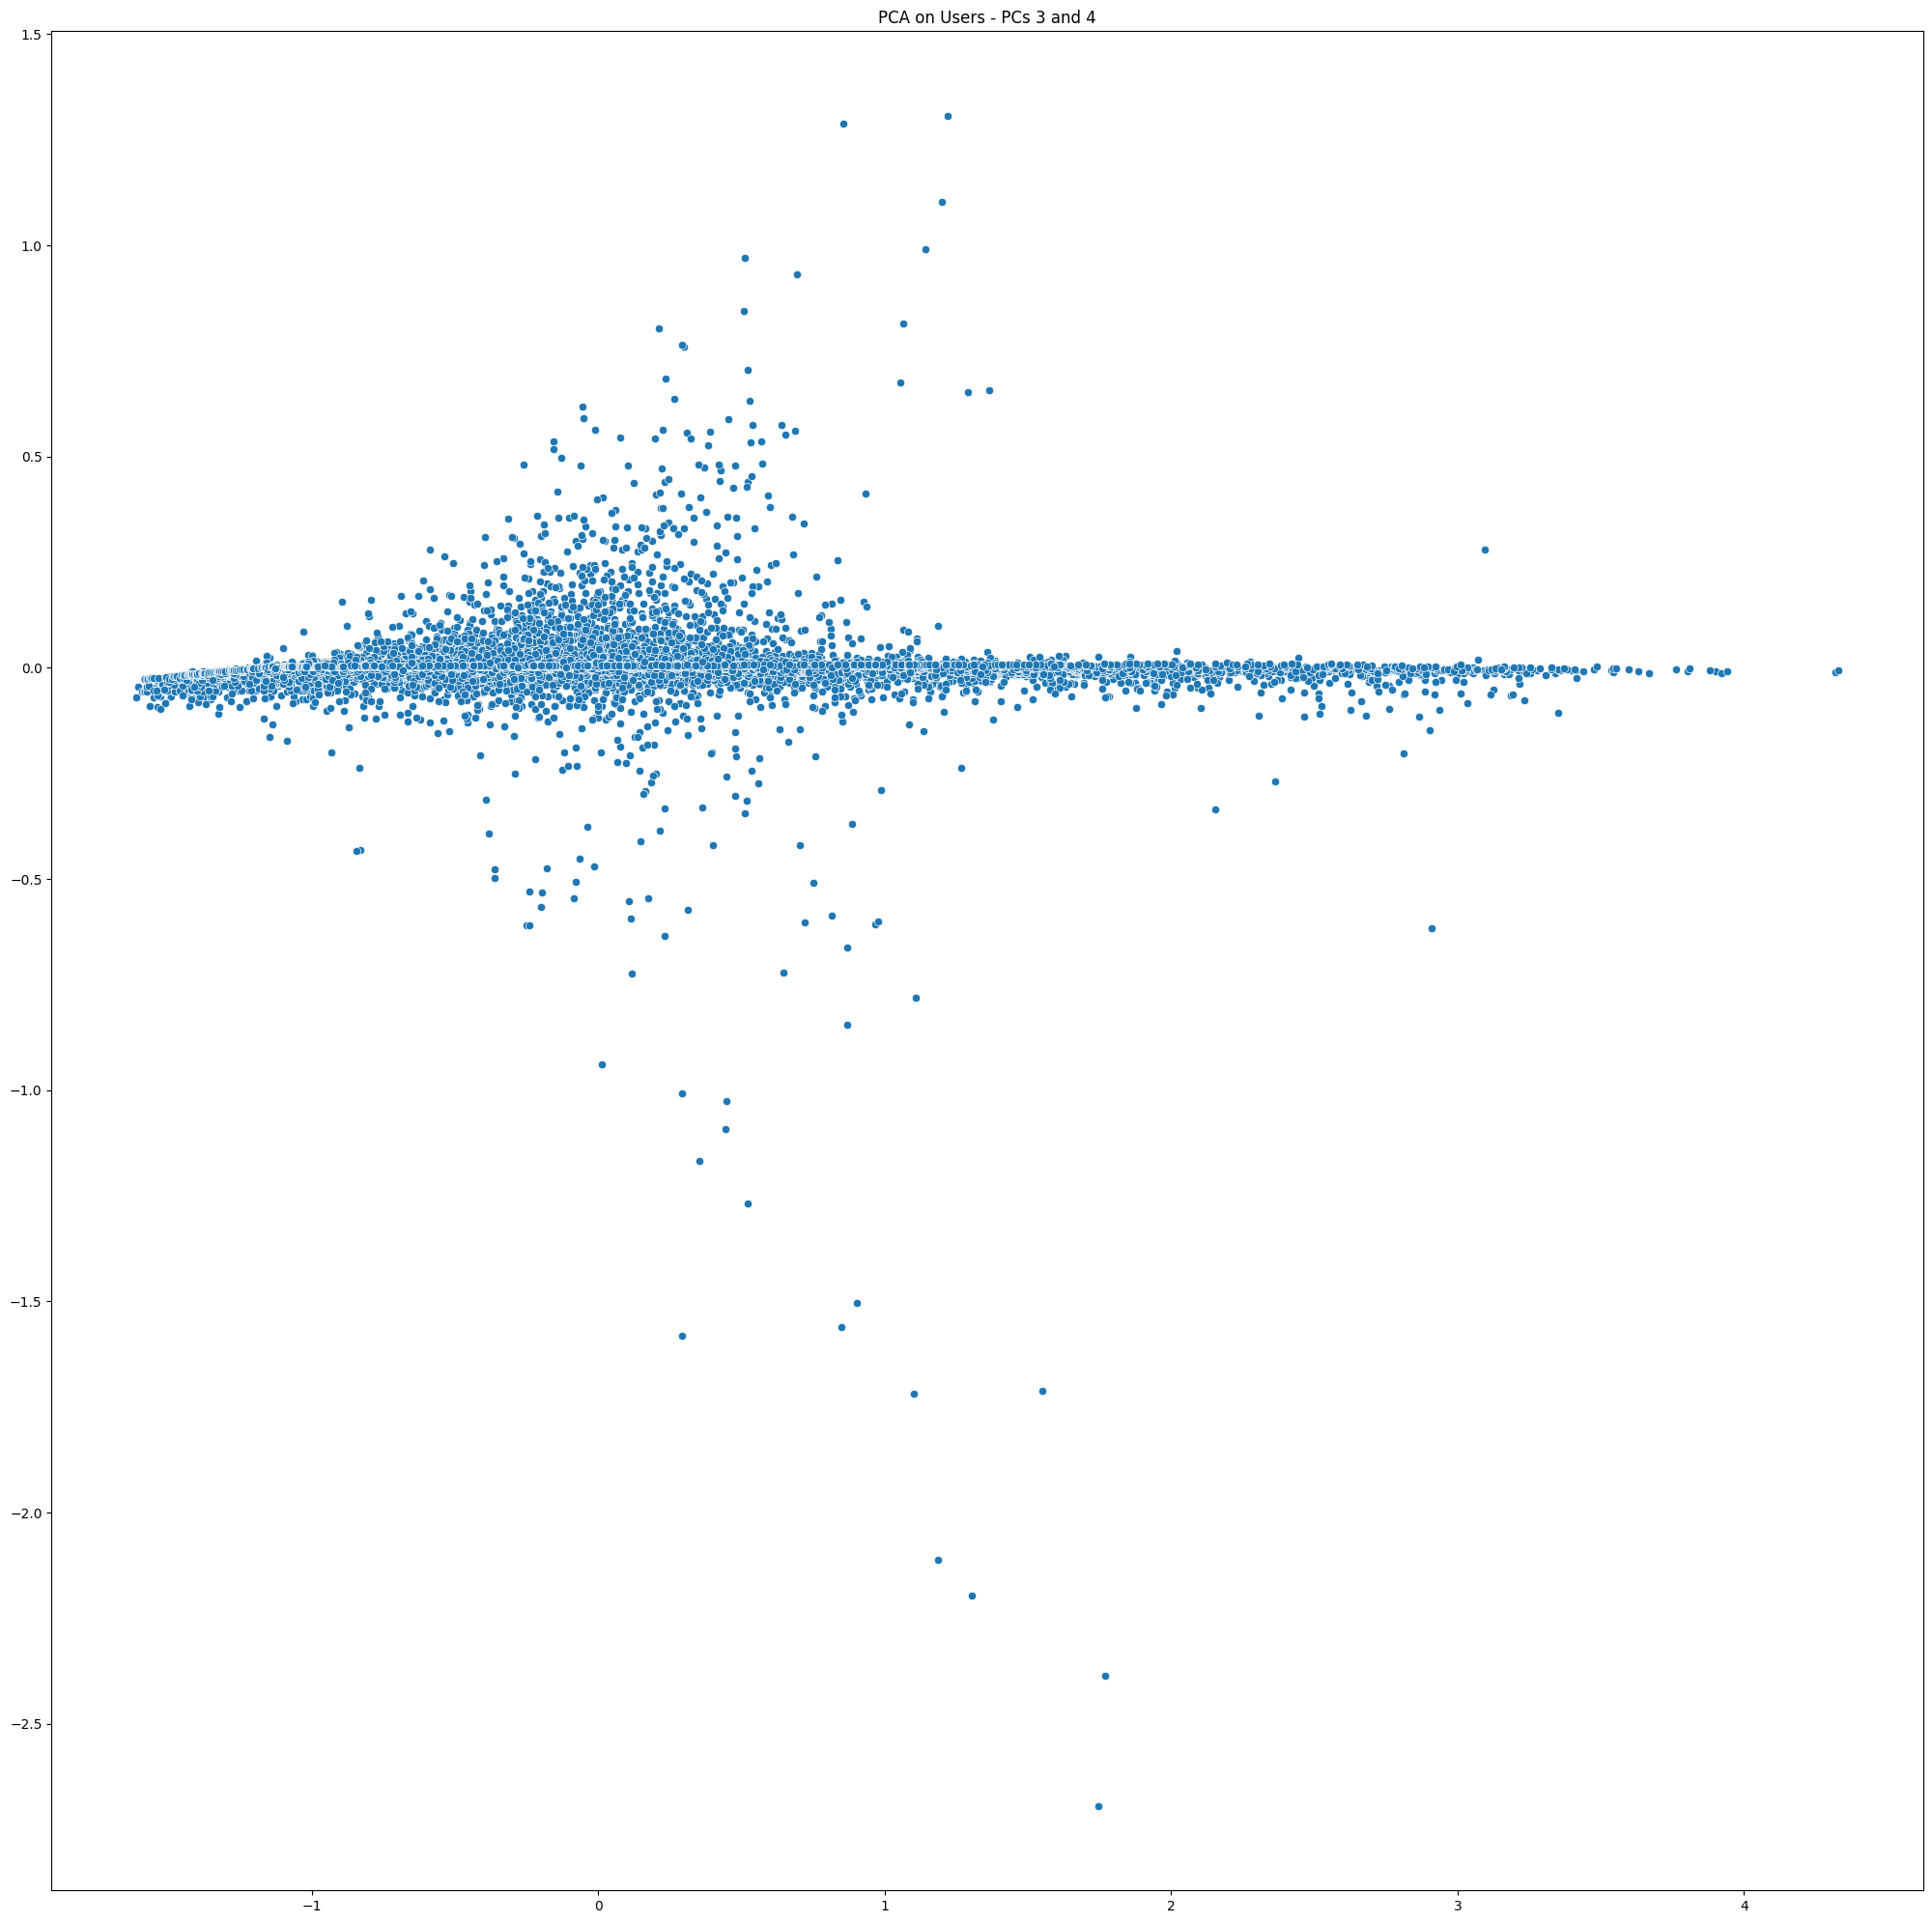

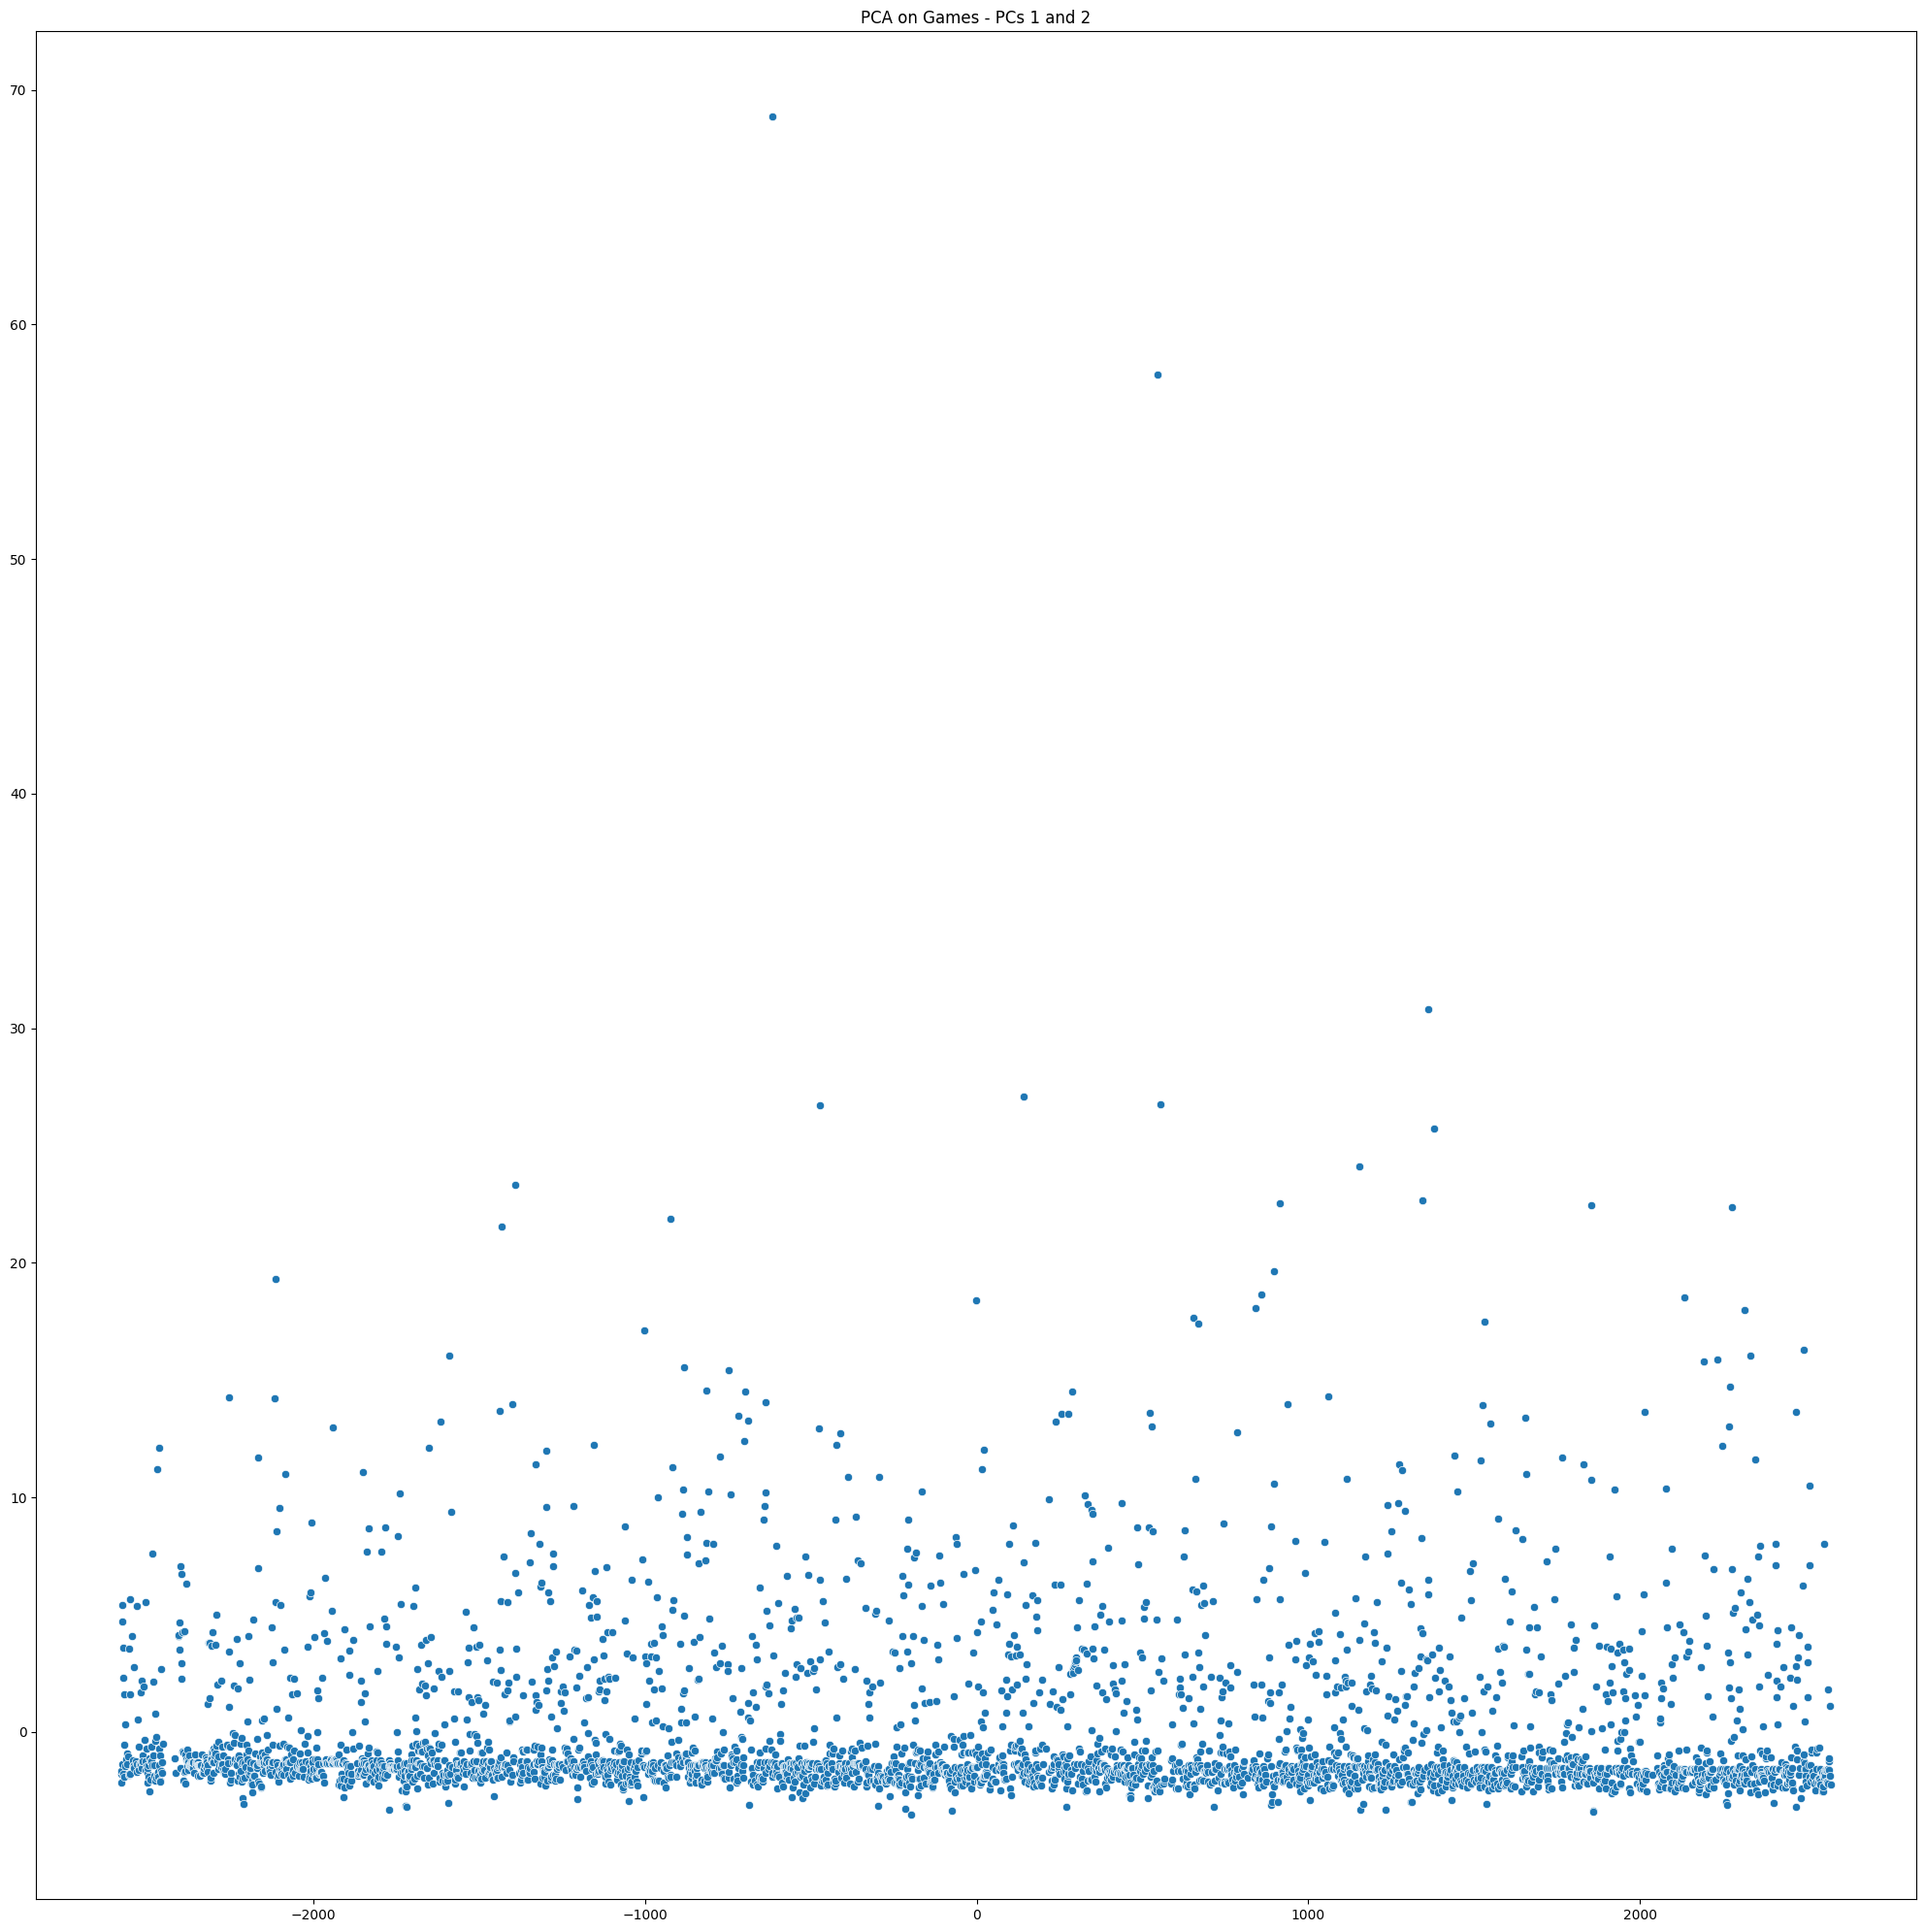

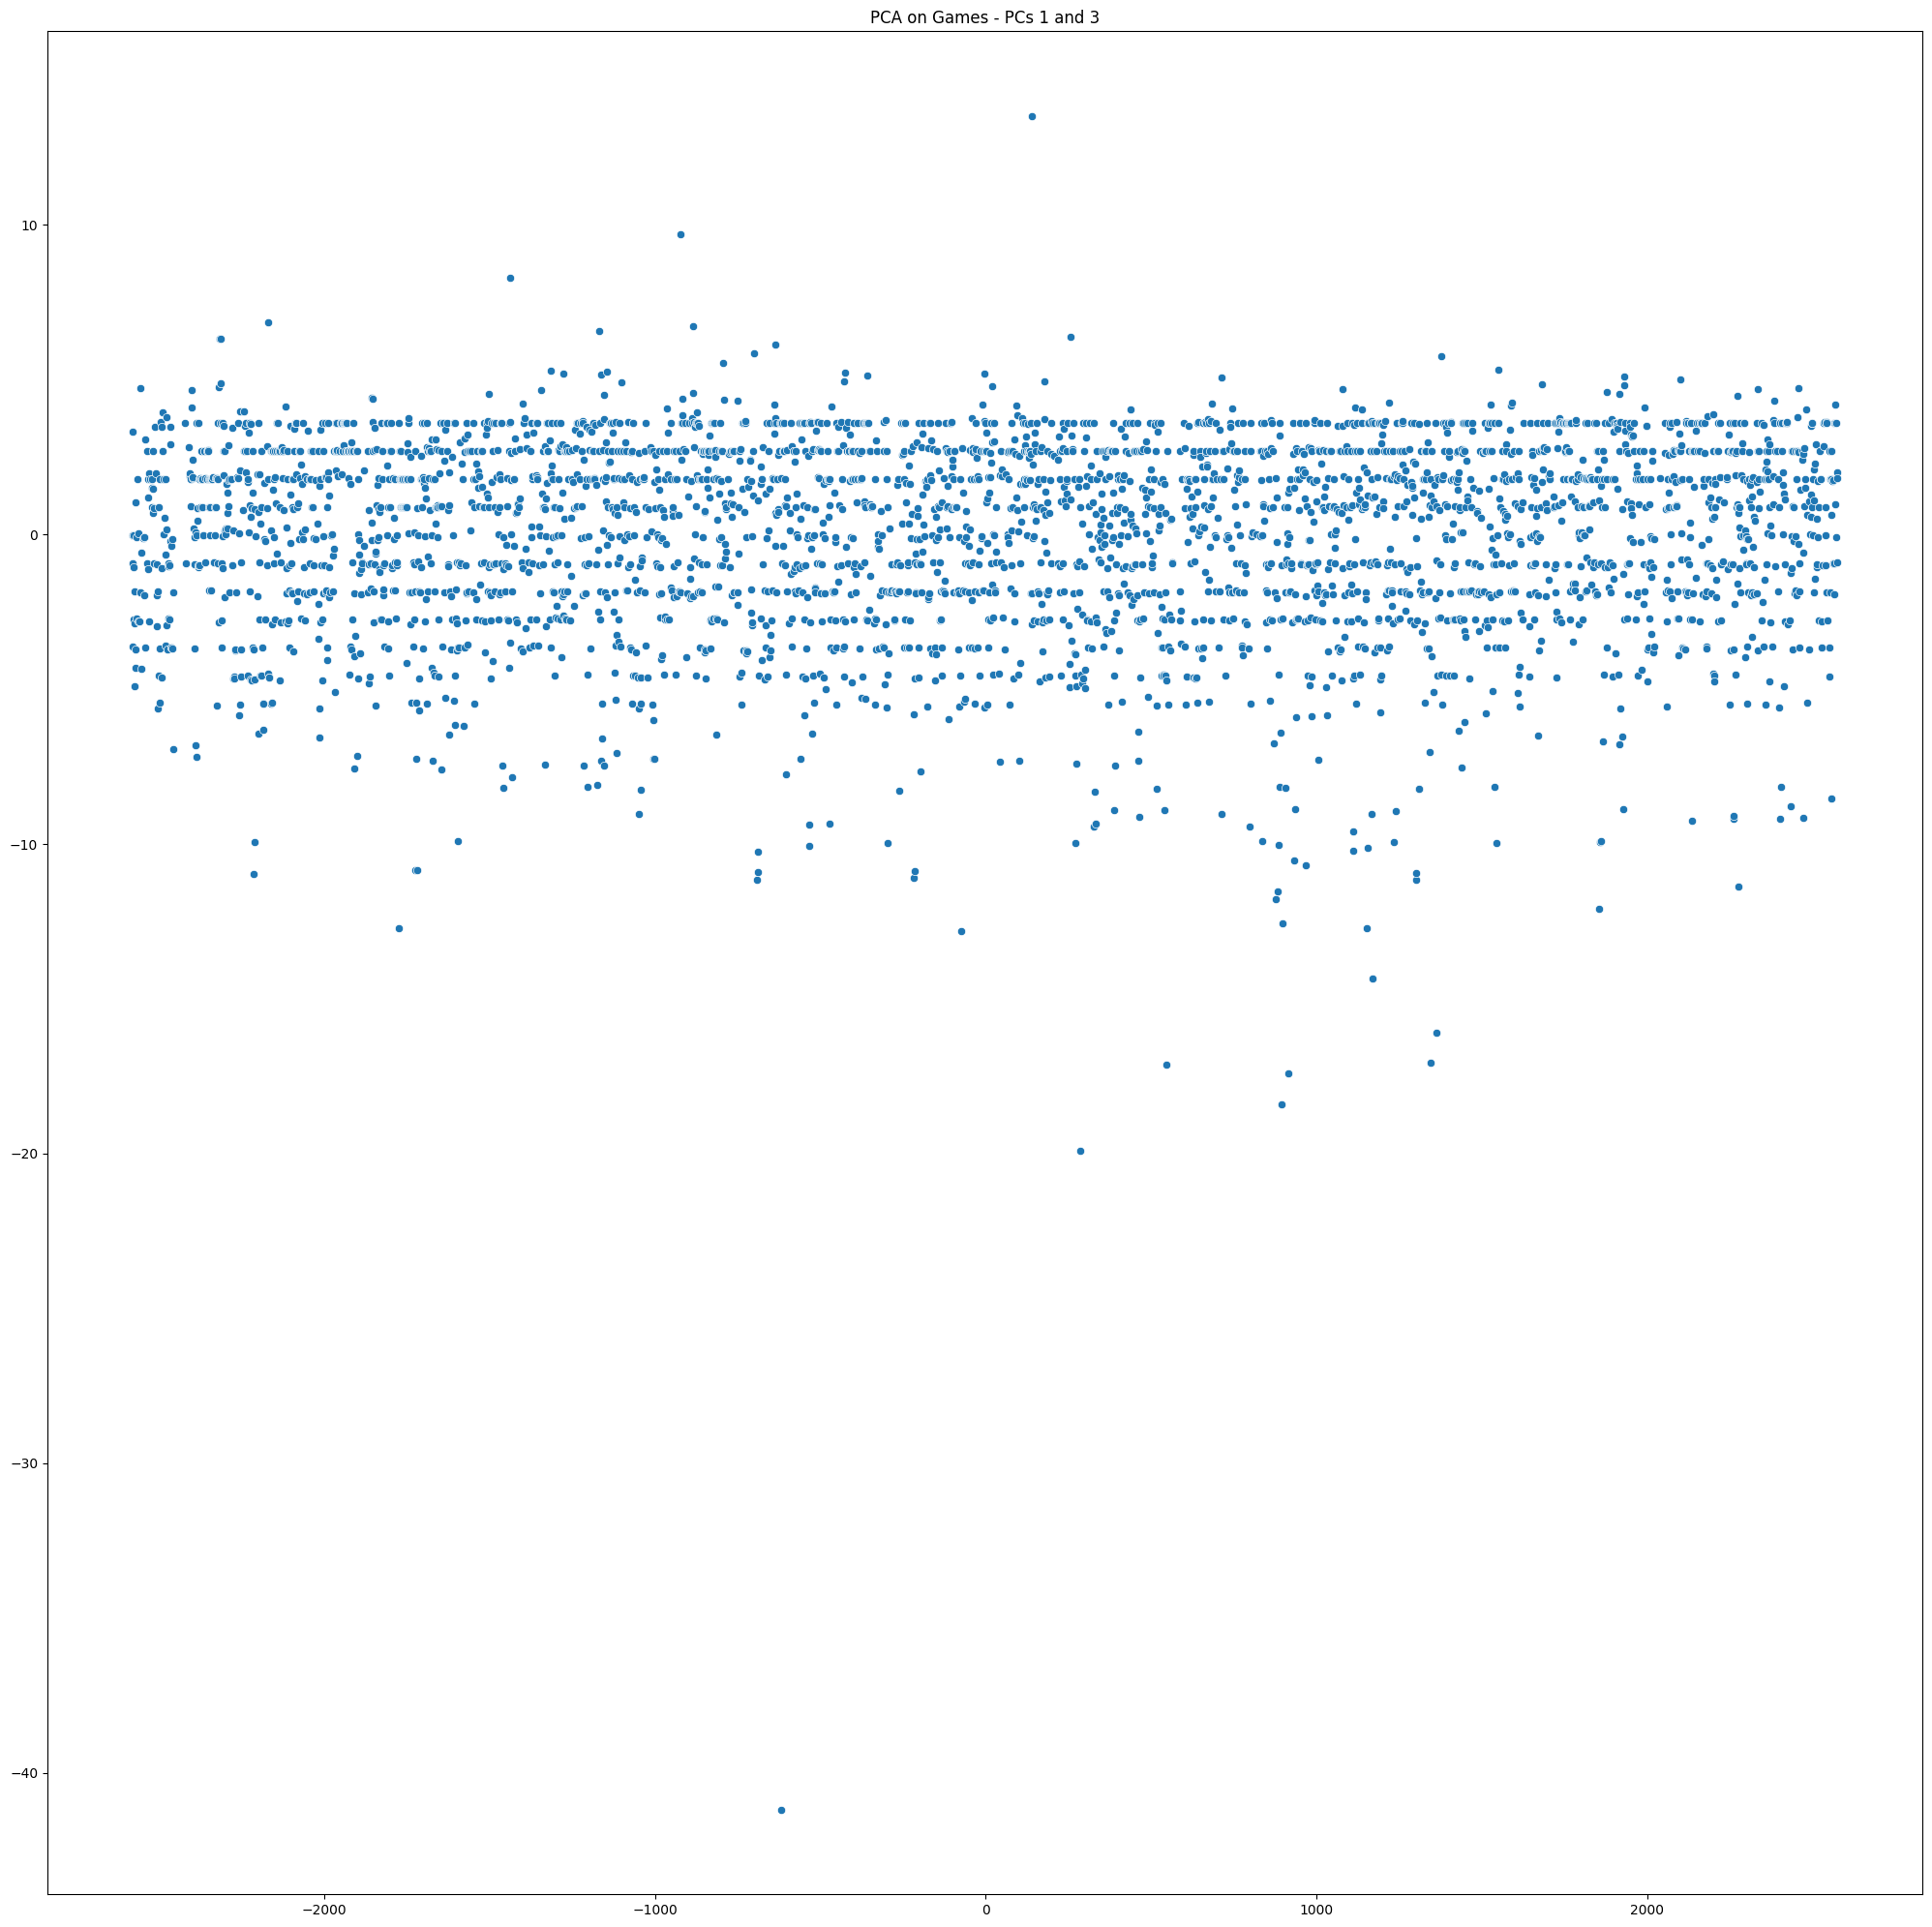

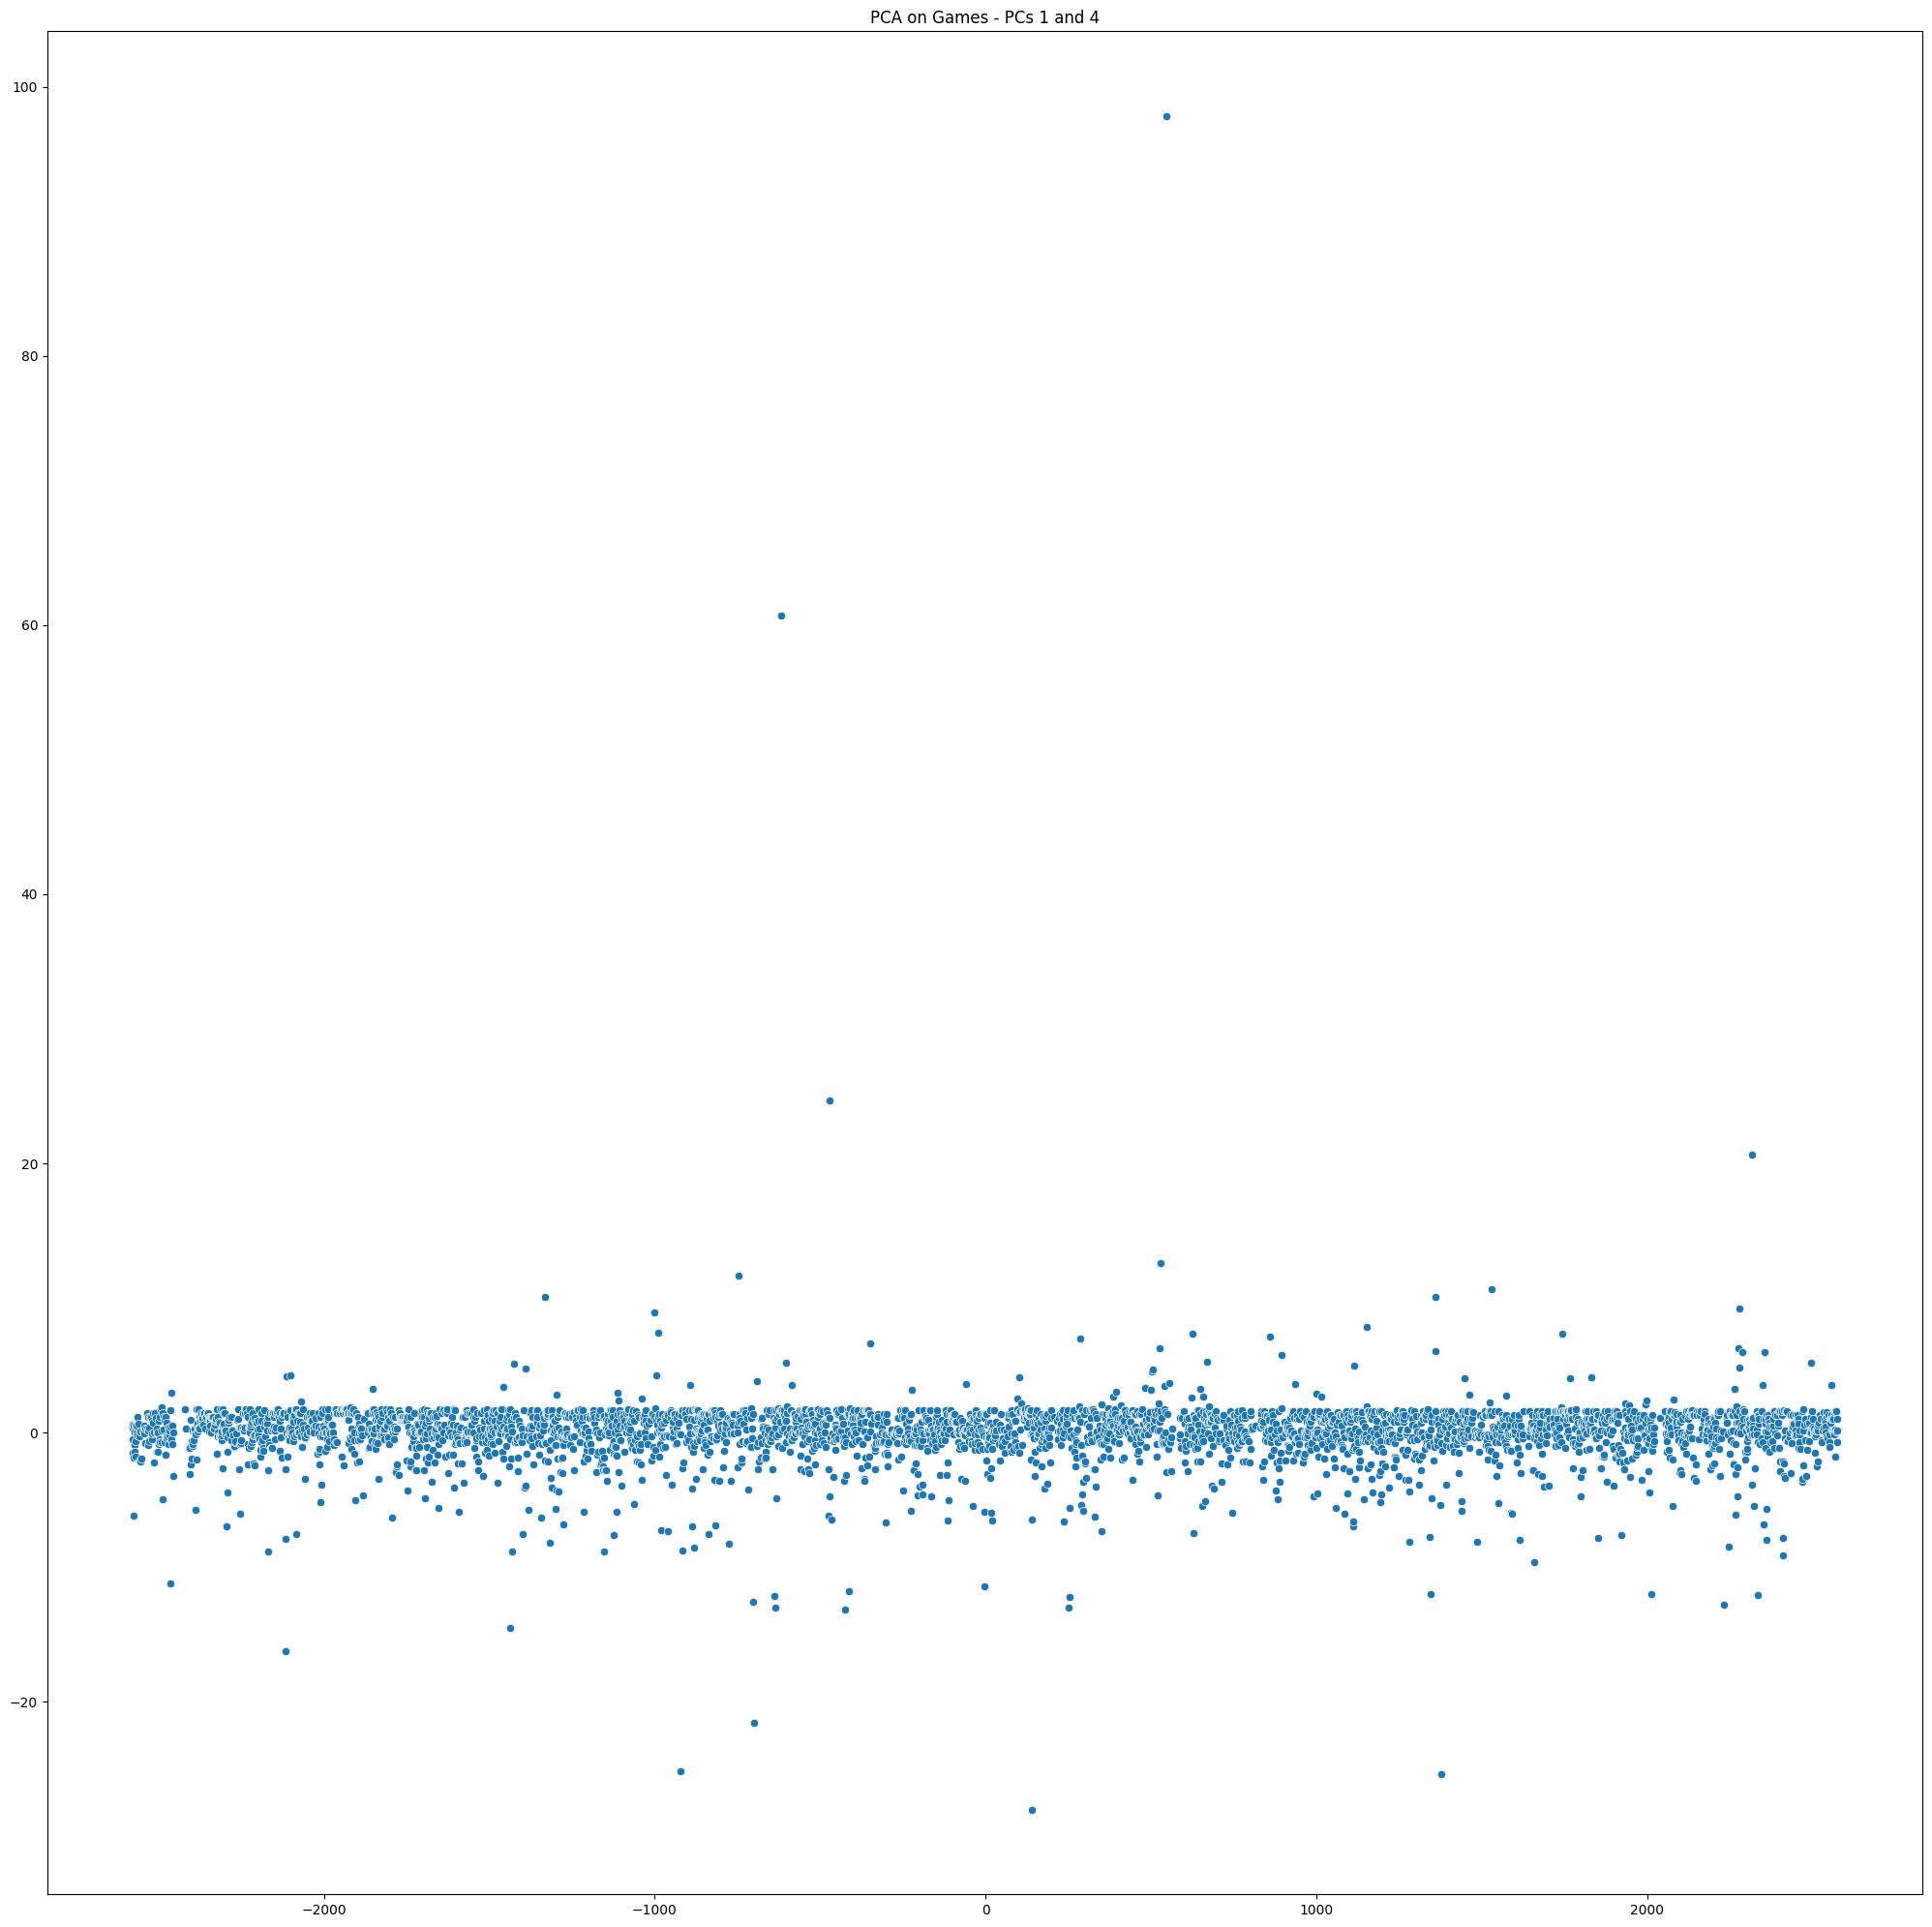

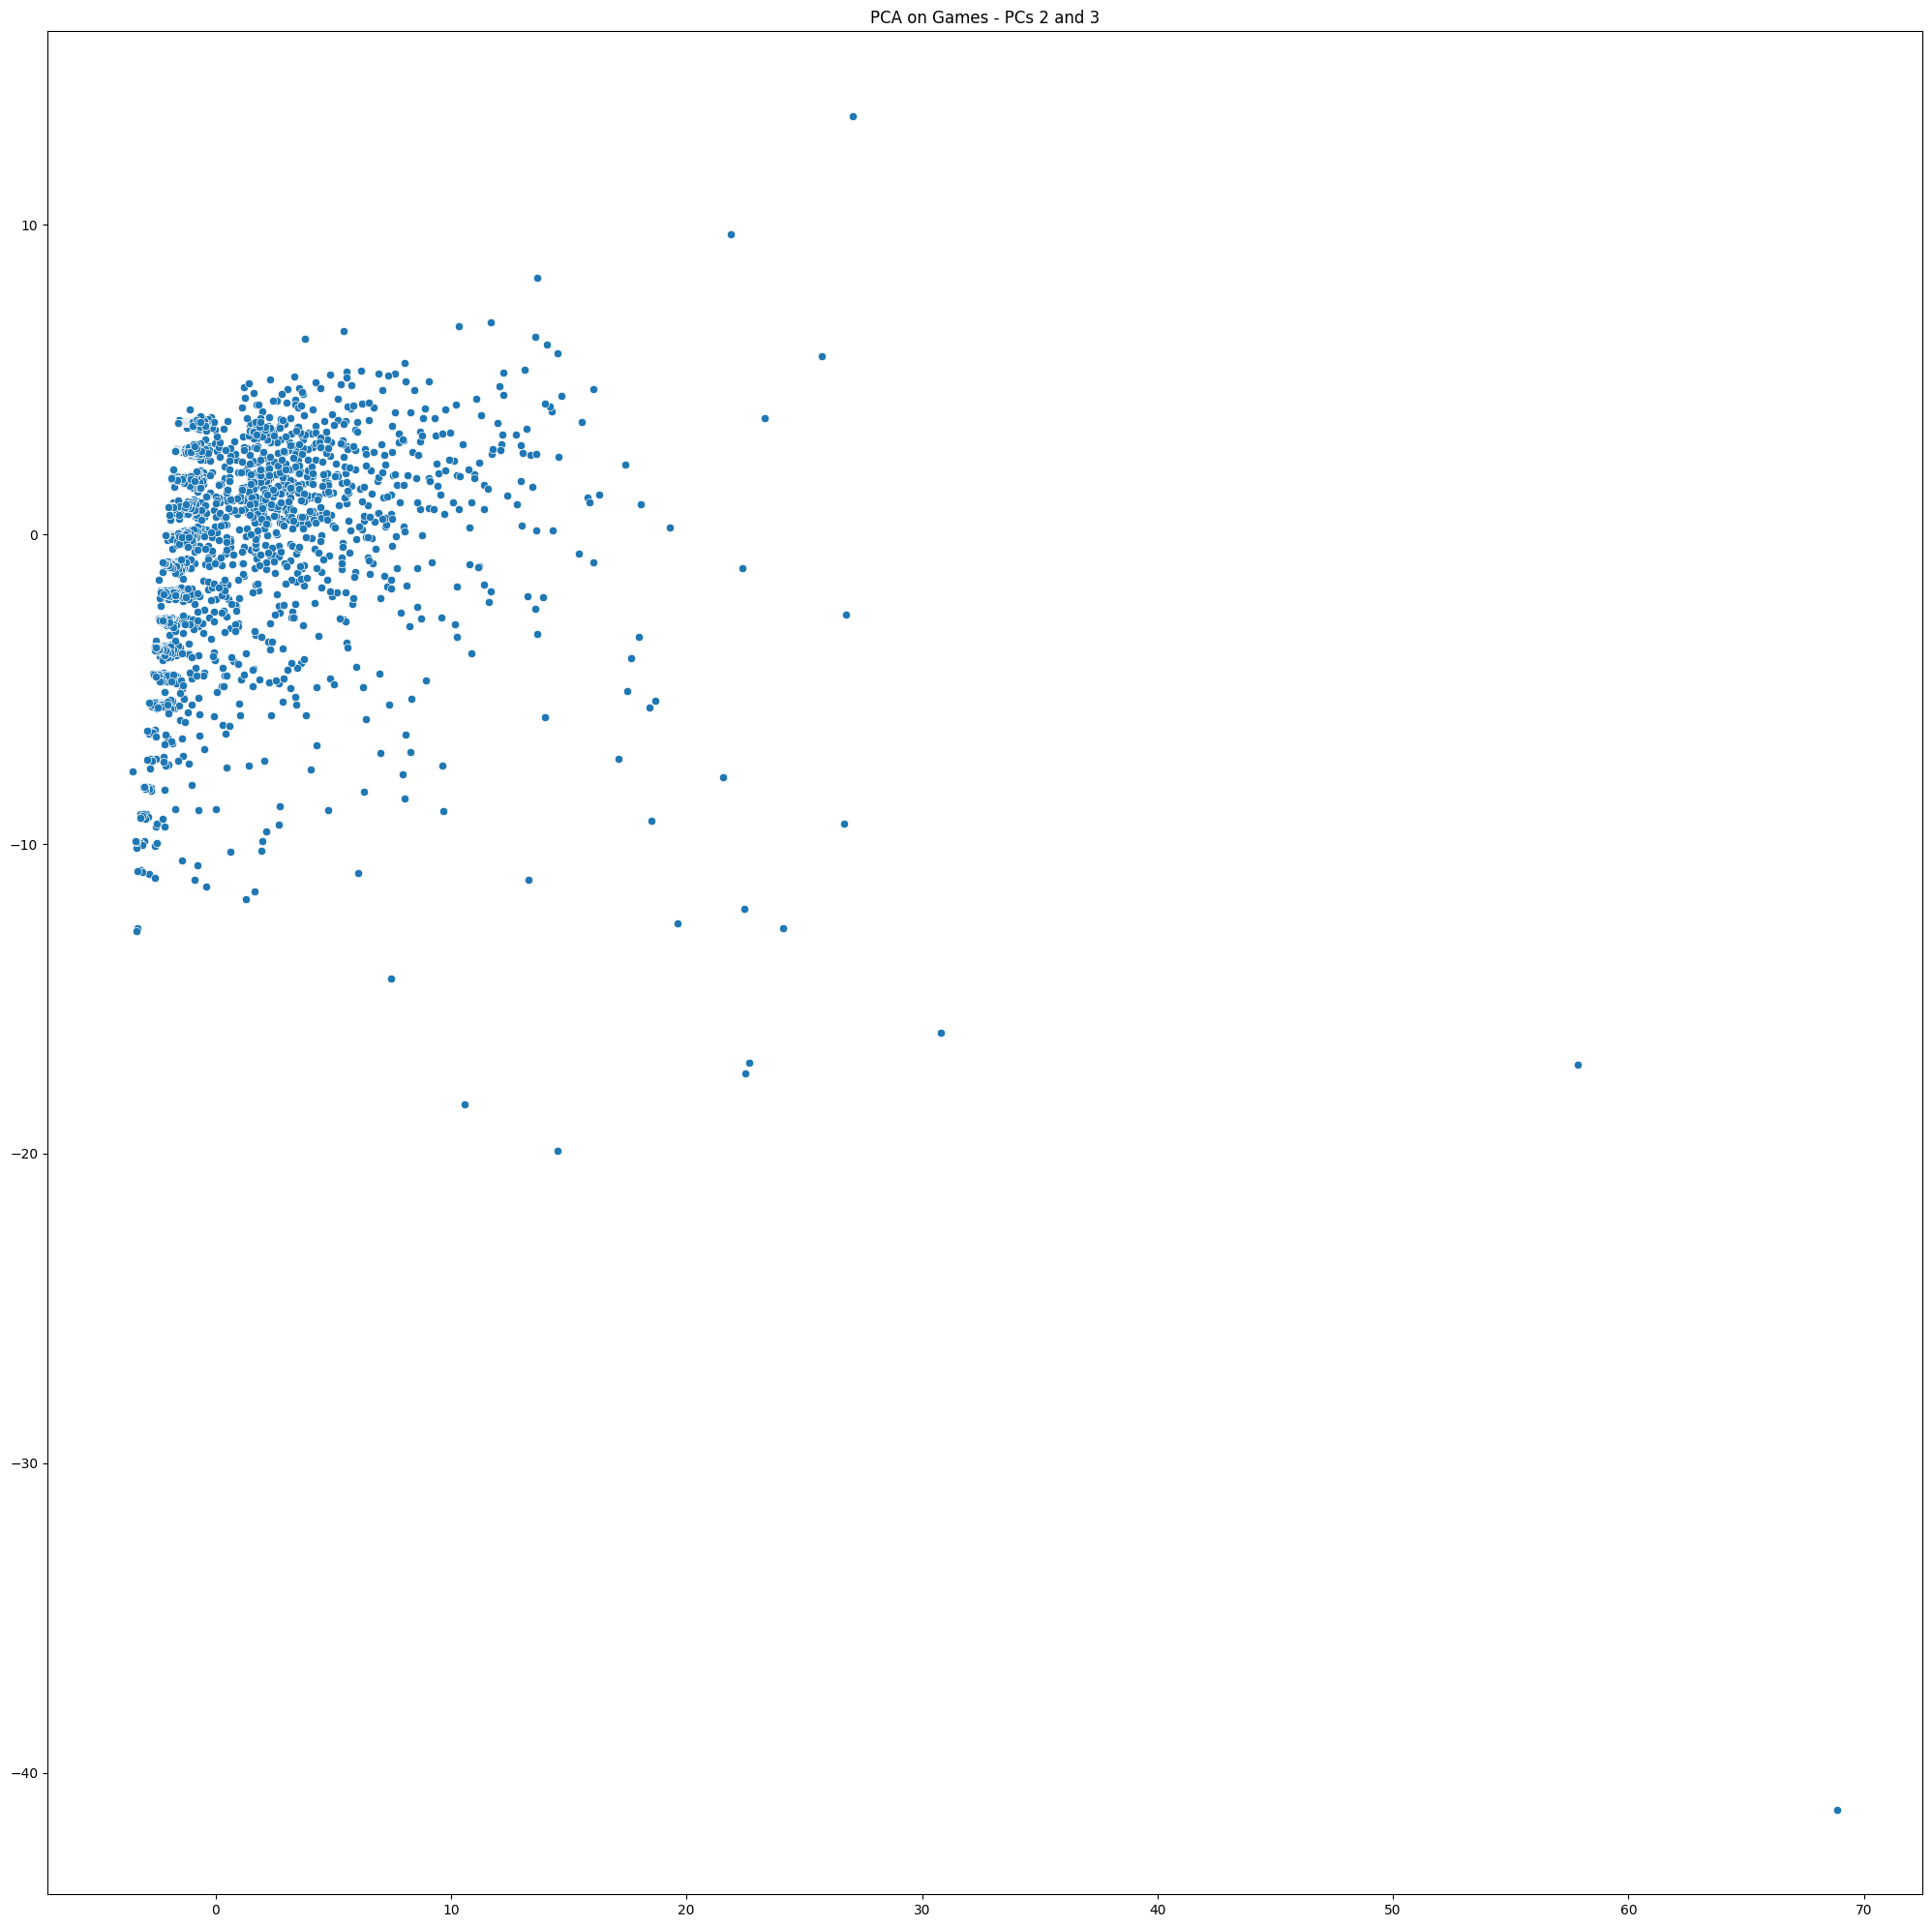

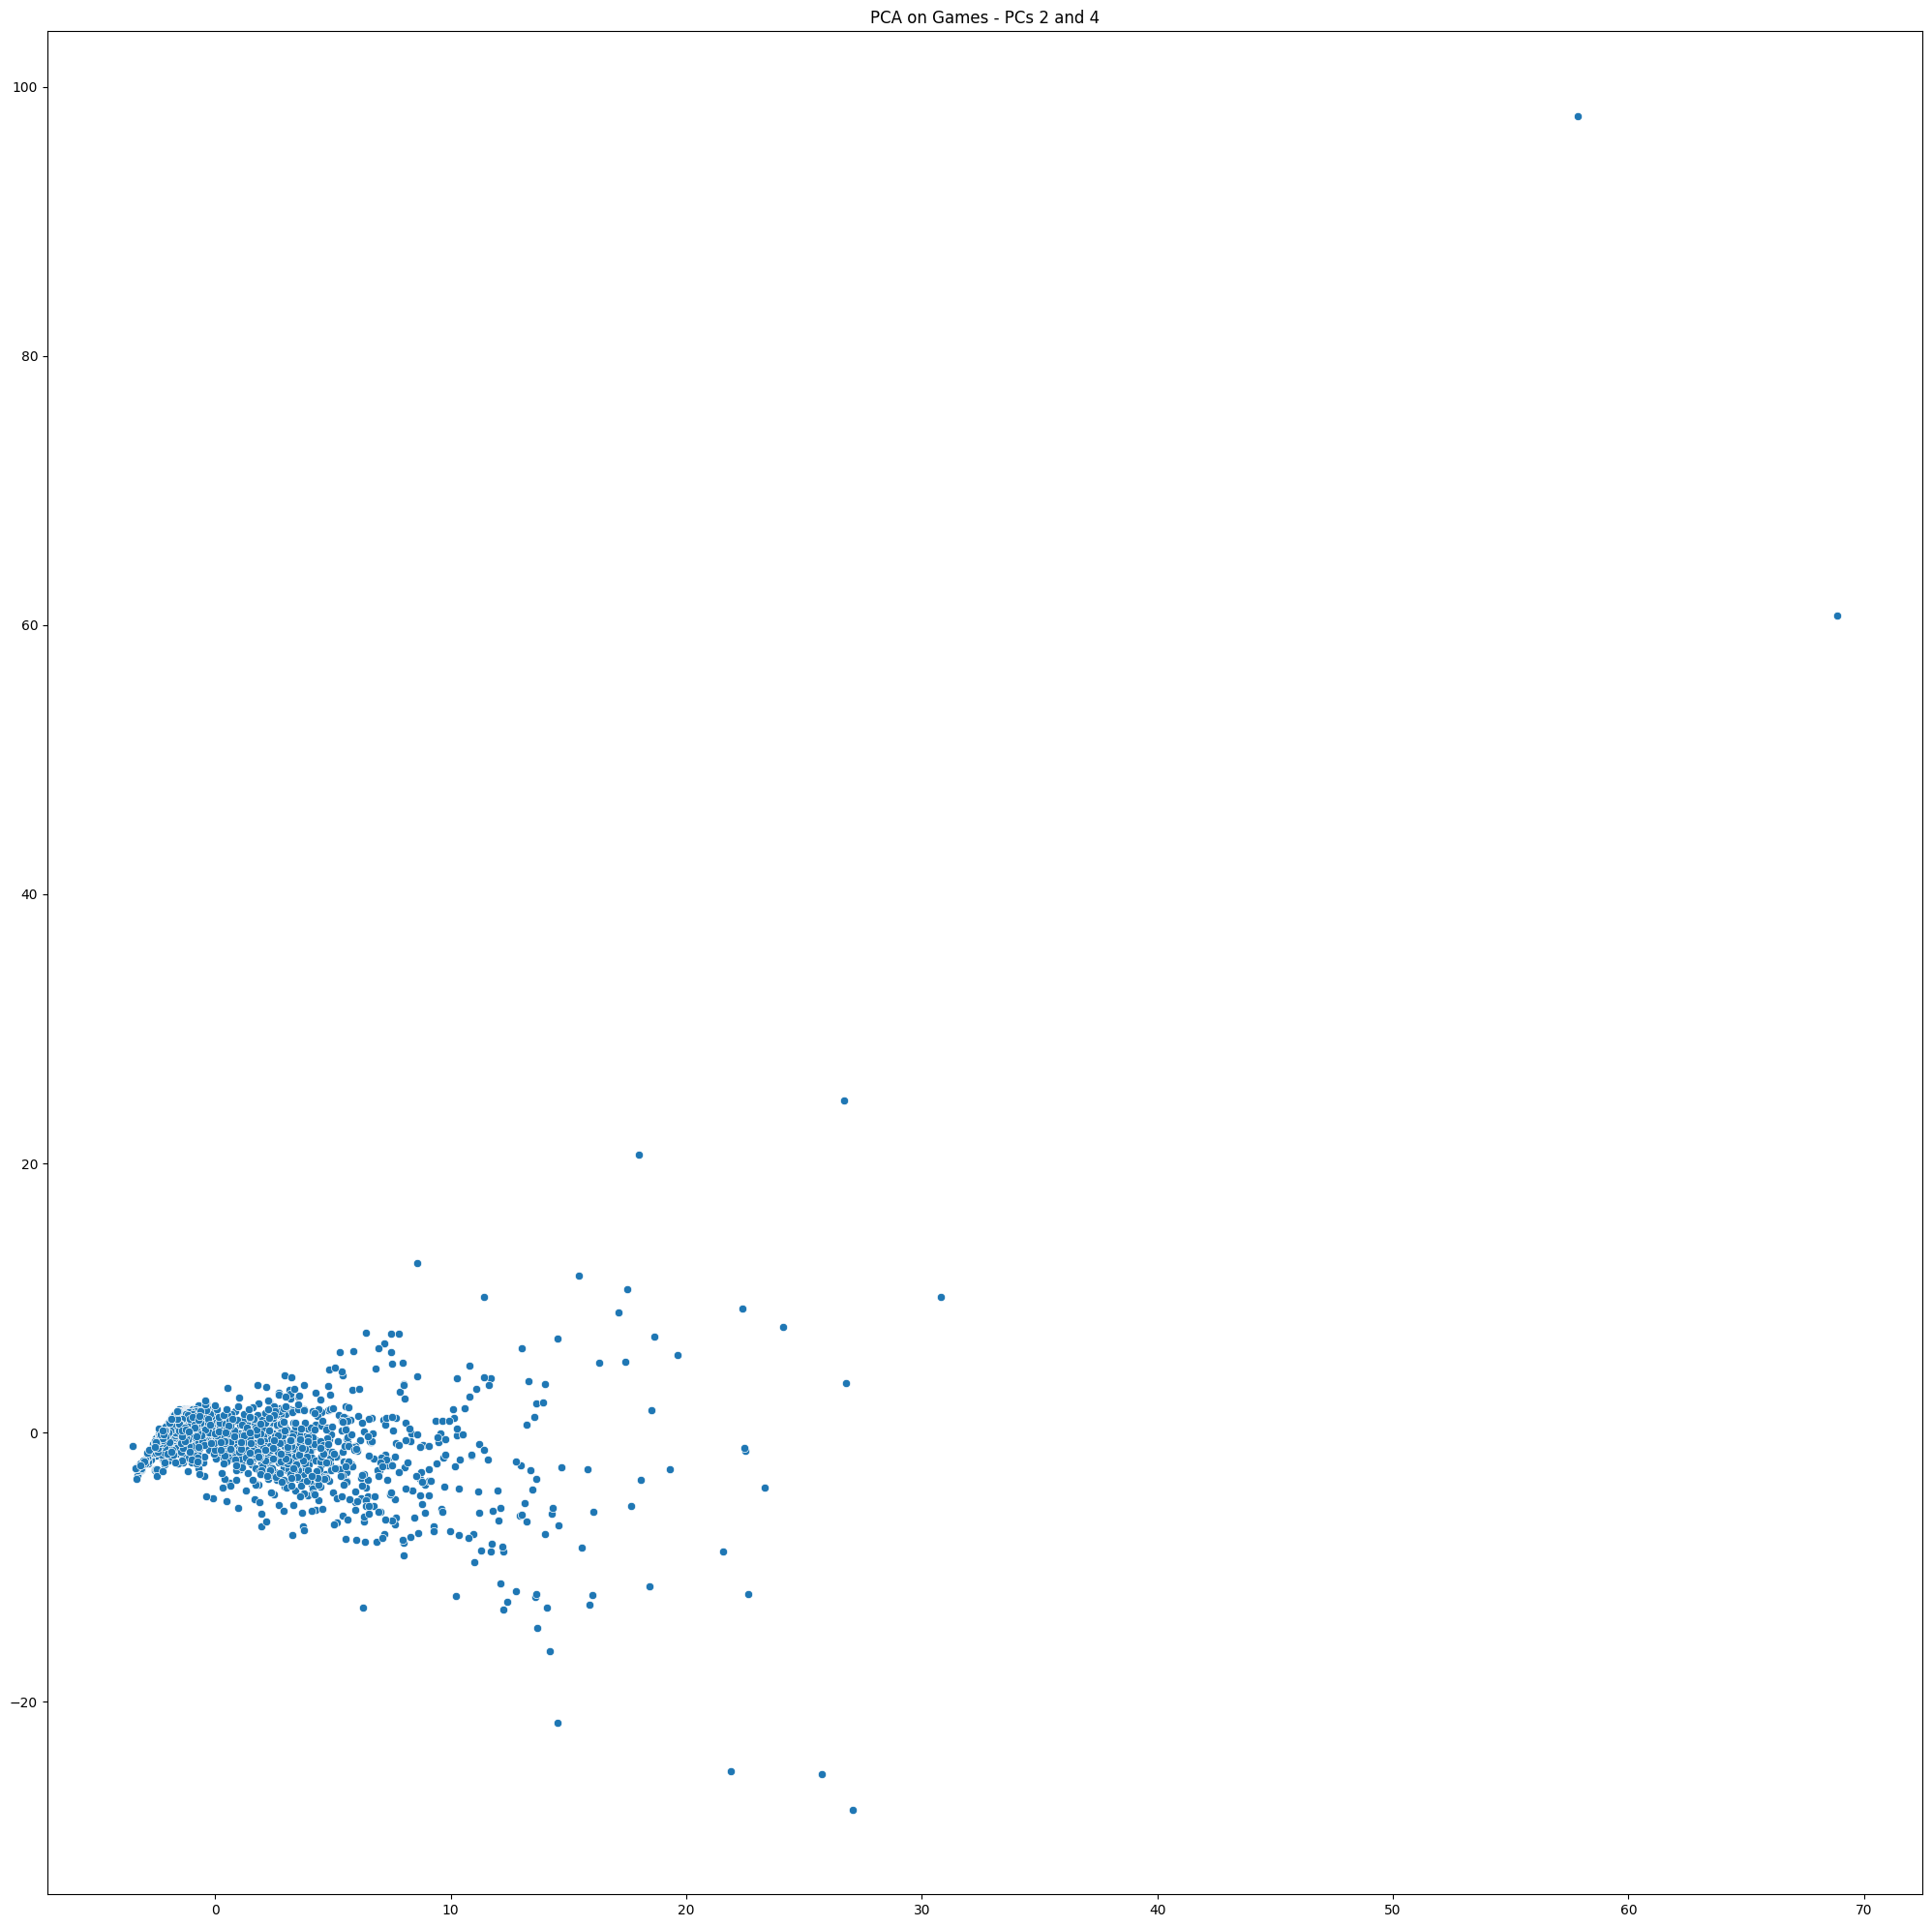

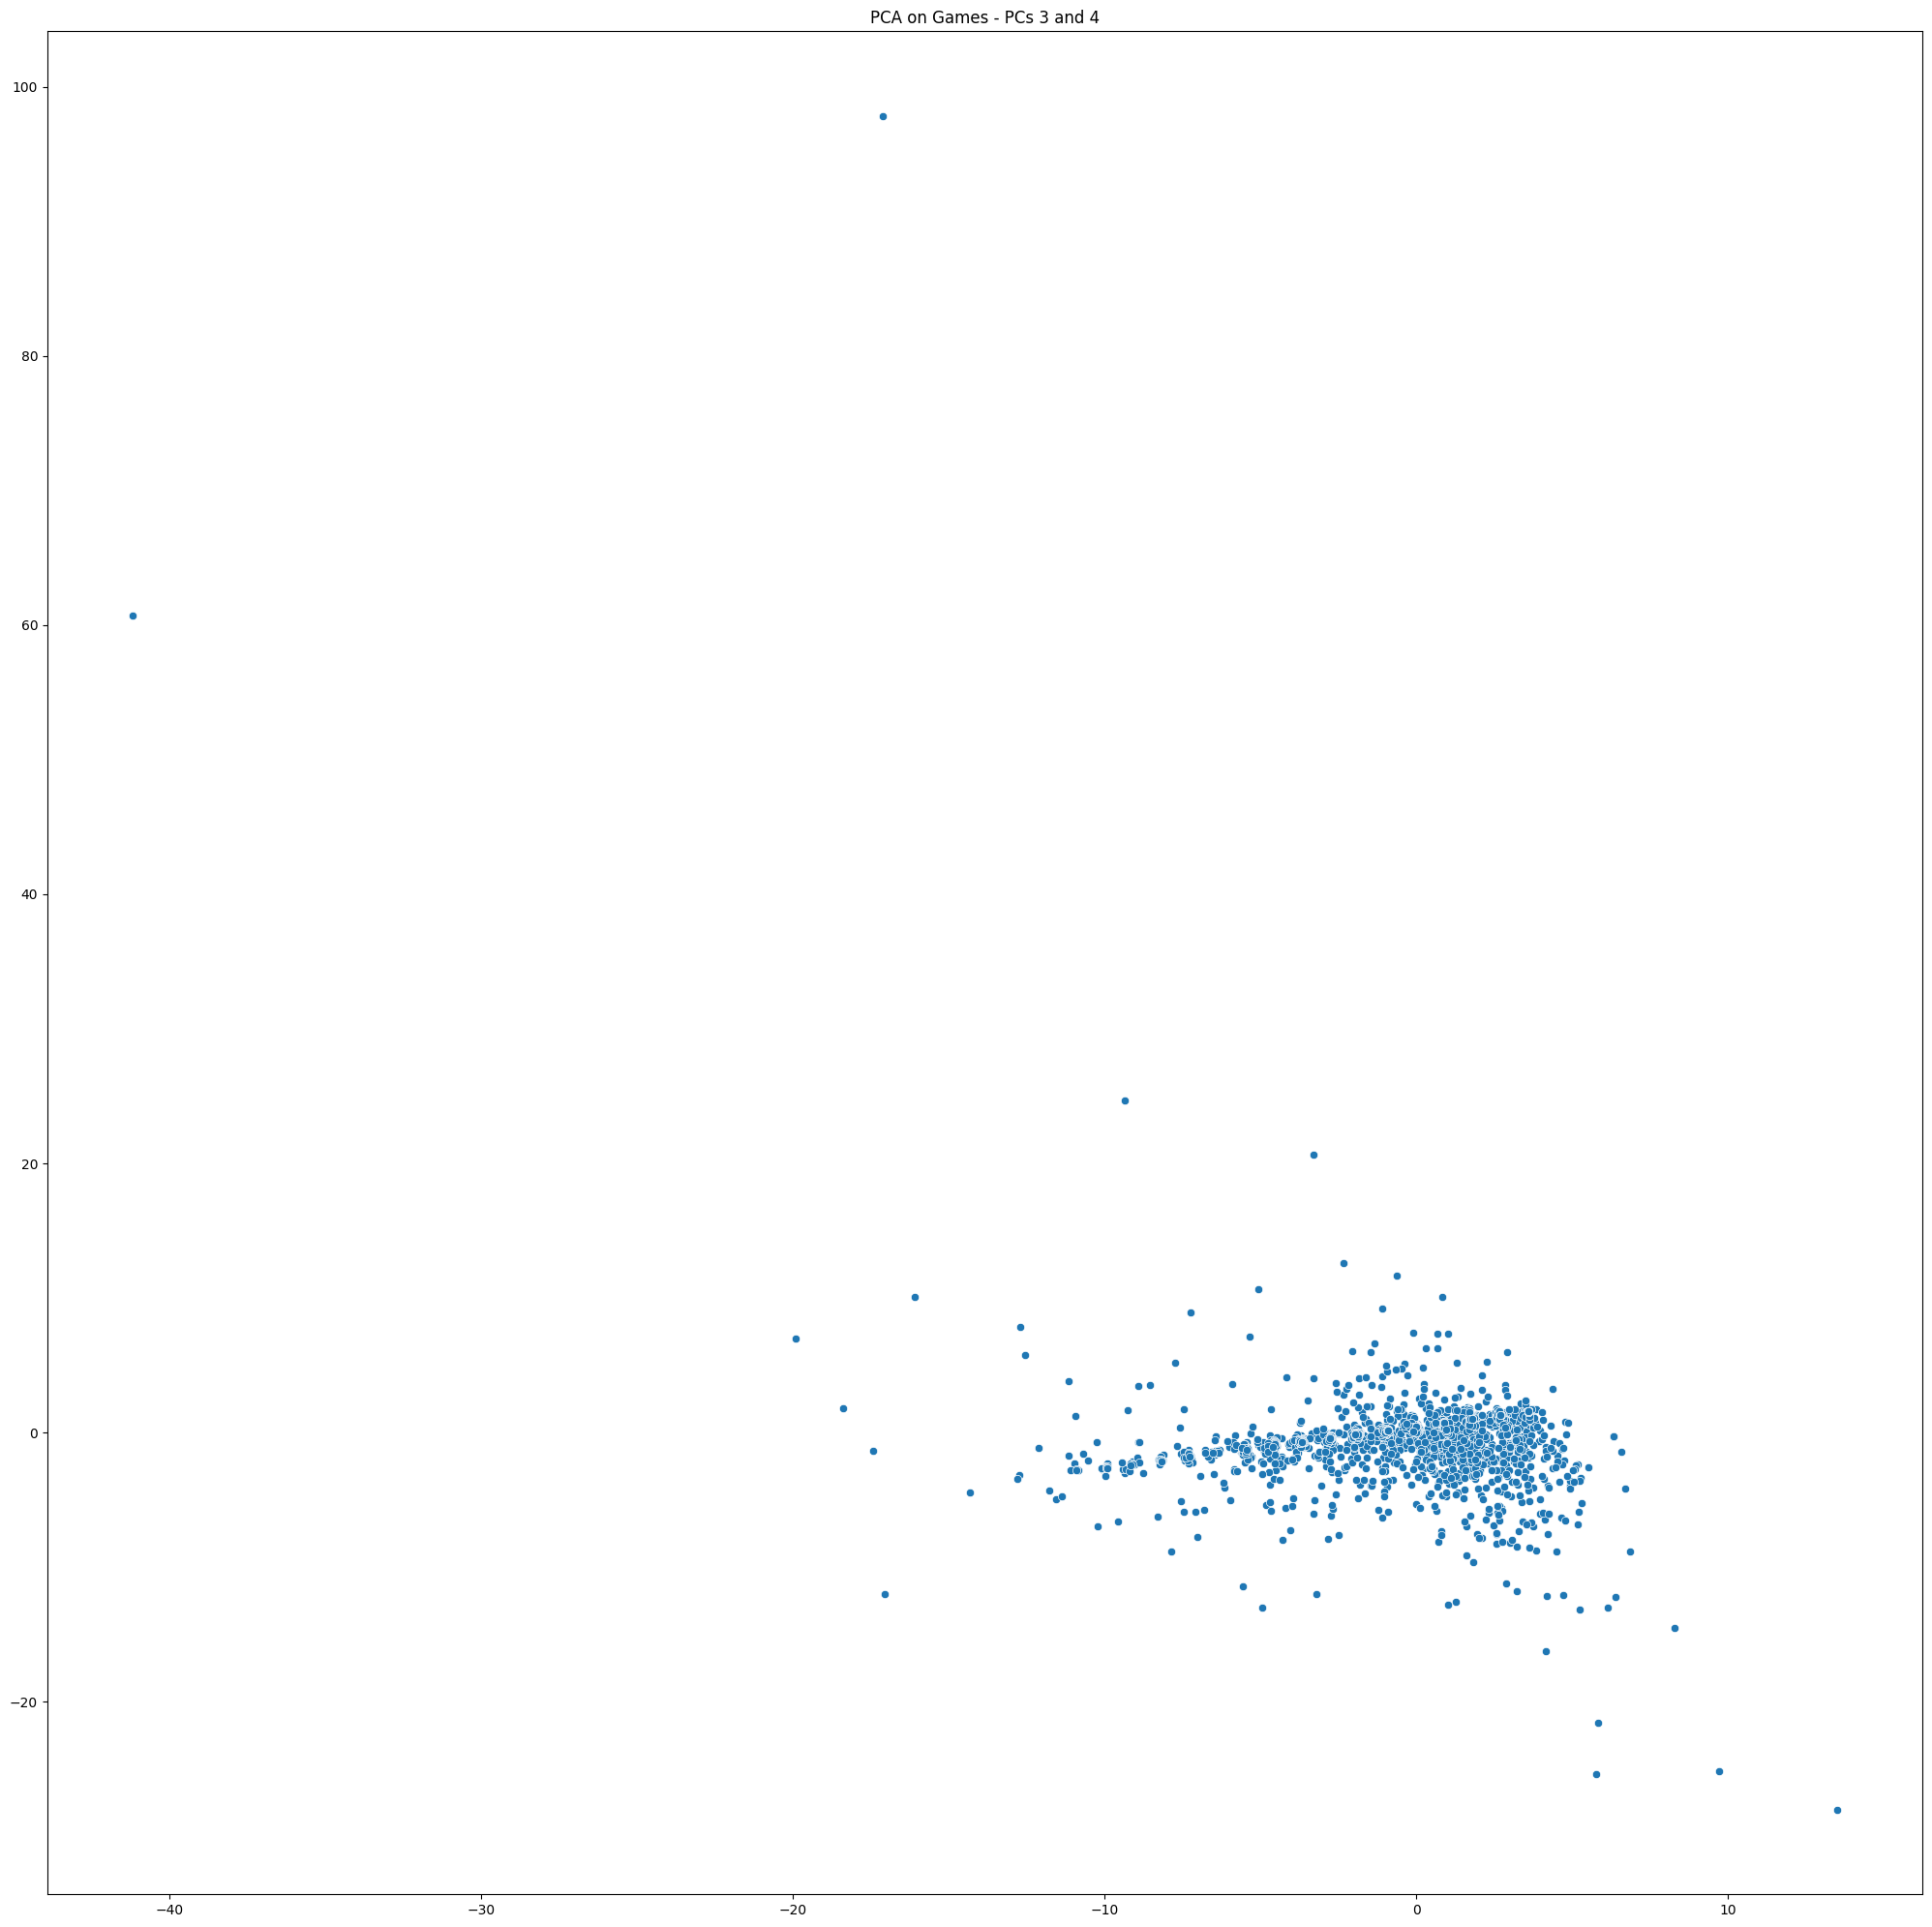

<ipython-input-19-c196ff5cb822>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  game_features['game_cluster'] = kmeans_game.fit_predict(game_features)


User Features with Clusters:
   user_id  avg_hours_in_game  purchase_no_play  num_bought    pca_user_1  \
0     5250           0.110652          0.262767    0.177870 -1.608568e+08   
1    76767           0.387933          0.664164    0.714683 -1.607853e+08   
2    86540          -0.344121          1.895115    1.473626 -1.607755e+08   
3   144736          -1.337798         -0.085110   -0.155324 -1.607173e+08   
4   181212          -0.966969          0.021929   -0.062770 -1.606808e+08   

   pca_user_2  pca_user_3  pca_user_4  user_cluster  
0   -0.348443   -0.125671   -0.076696             4  
1    0.287755    0.209601    0.020591             4  
2    1.754982   -0.393261   -0.312631             4  
3   -0.698335   -1.611100   -0.069958             4  
4   -0.590689   -1.229077   -0.079234             4  

Game Features with Clusters:
   game-title  avg_playtime  purchase_no_play  total_playtime  total_players  \
0           0      -0.98809         -0.265501       -0.141967      -0.2643

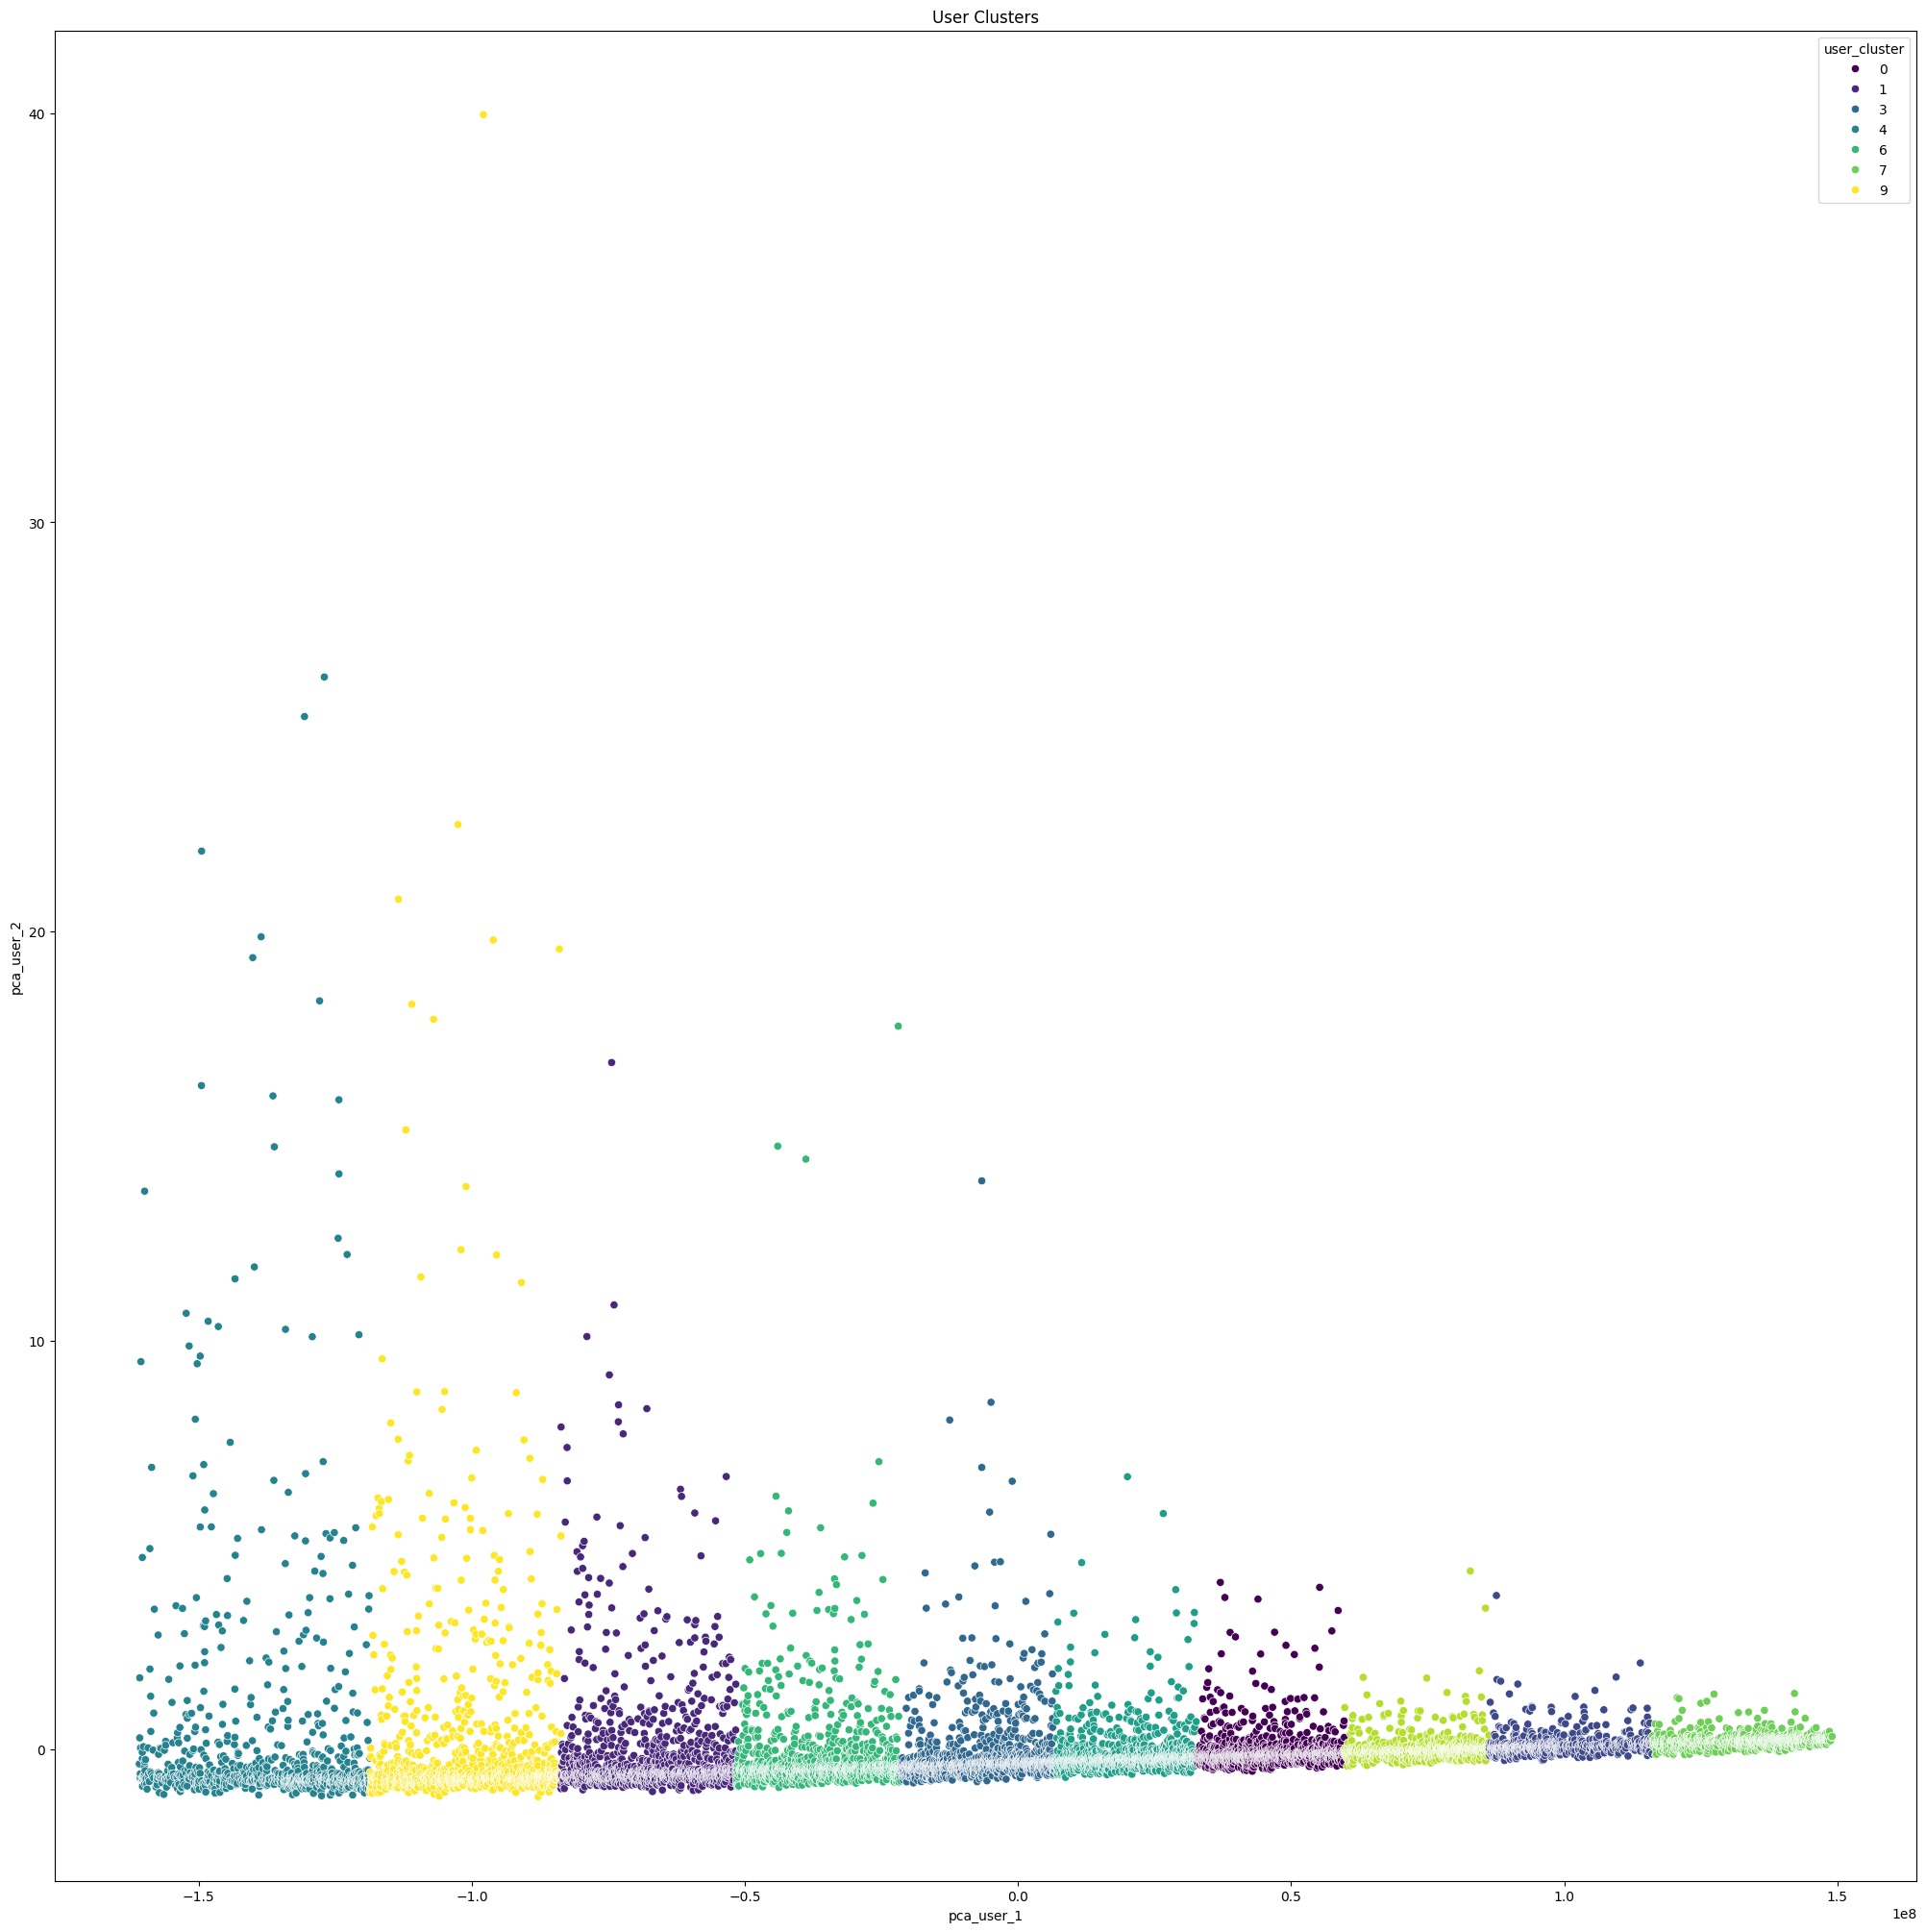

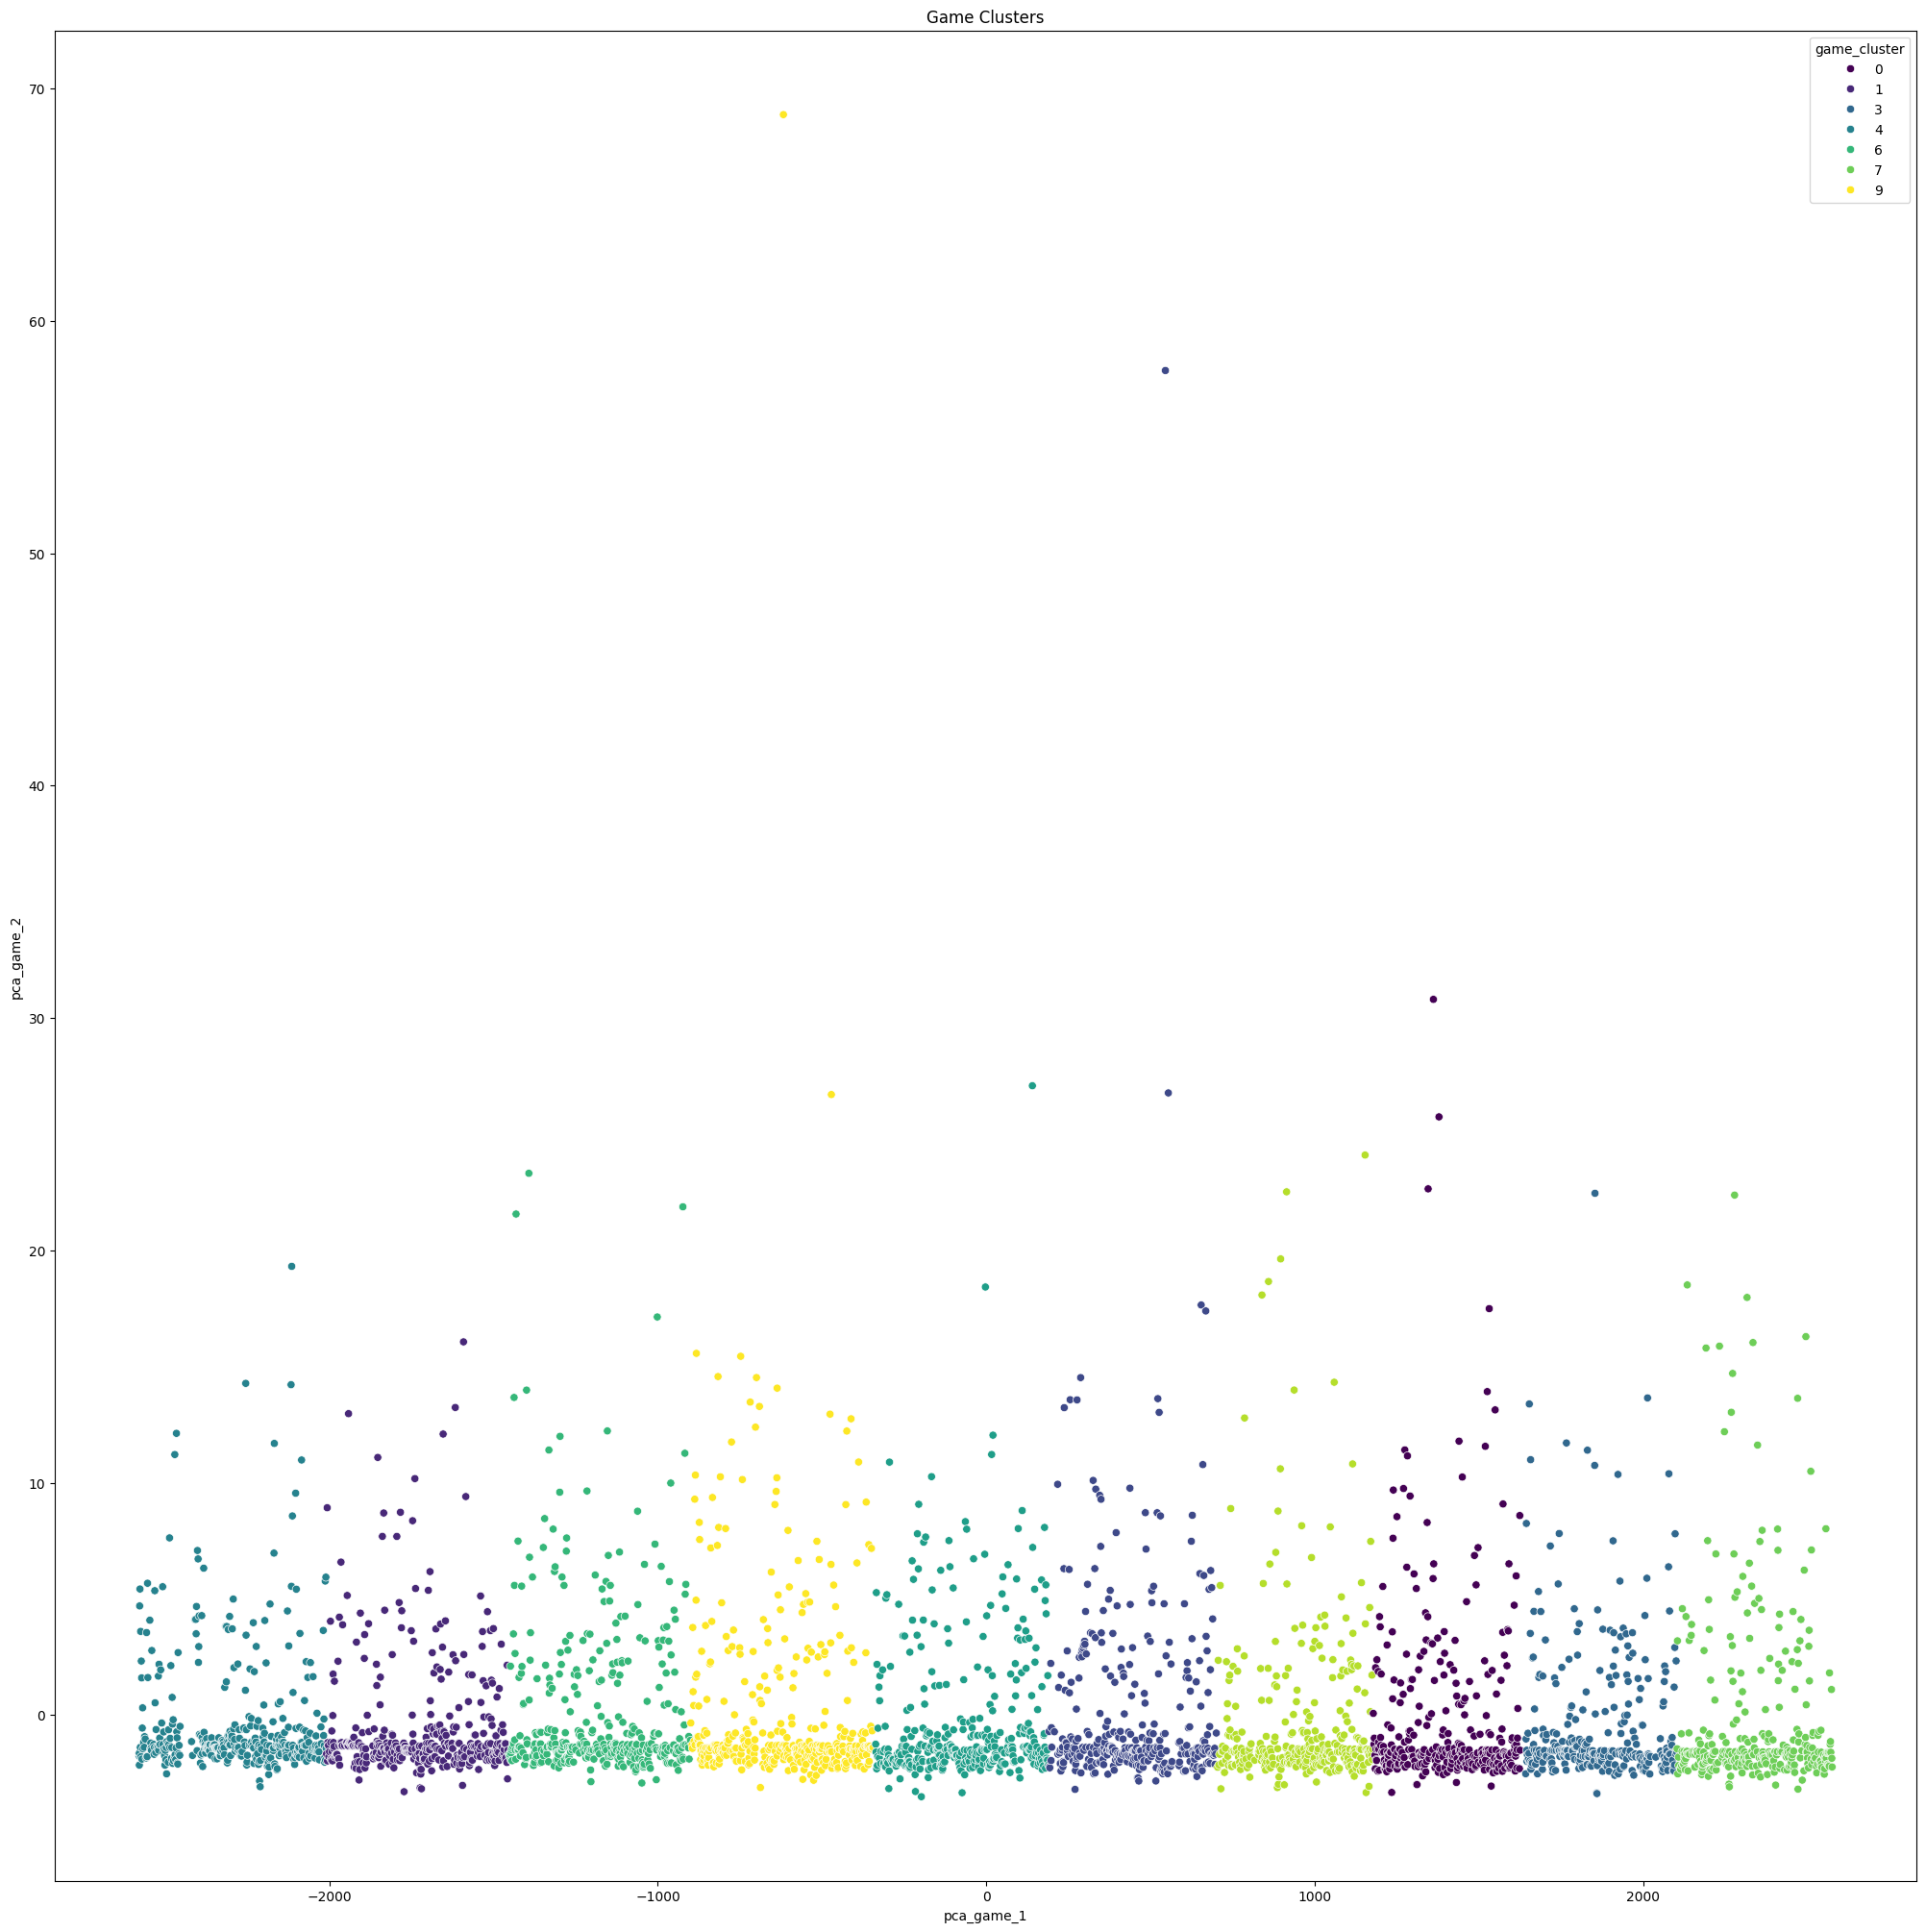

In [30]:
user_features, game_features = perform_PCA(user_features, game_features)

user_features, game_features = perform_KMeans(user_features=user_features, game_features=game_features, seed=seed)

In [31]:
data_copy = None

data_copy = data.merge(user_features[user_features.columns.values], on='user_id', how='left')
data_copy = data.merge(game_features[game_features.columns.values], on='game-title', how='left')

data_copy['behavior-name'] = data_copy['behavior-name'].apply(lambda x: 0 if x == 'purchase' else 1)

data_copy.dropna(inplace=True)

model = regression_model(data_copy, seed)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=7.62066e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Root Mean Squared Error (Train): 0.03890022513398473
Mean Absolute Error (Train): 0.13692288401011468
Root Mean Squared Error (Test): 0.03894529793104066
Mean Absolute Error (Test): 0.13741285368783637


In [32]:
random_testing(data_copy, model, game_features)

Game Title: 4095
Predicted Playtime: -0.15 hours
Actual Playtime: 0.026914863428021258
Average Playtime for '4095': -0.23 hours
Recommendation: Recommend


In [ ]:
import numpy as np

print(user_features.head())

def recommend_games(user_id, data, user_features, game_features, label_encoder, top_n=10):
    user_cluster = user_features.loc[user_features['user_id'] == user_id, 'user_cluster'].values[0]

    similar_users = user_features[user_features['user_cluster'] == user_cluster]['user_id']

    similar_user_games = data[(data['user_id'].isin(similar_users)) & (data['behavior-name'] == 'play')]

    top_games = similar_user_games['game-title'].value_counts().head(top_n).index.tolist()

    recommended_games = []

    for game in top_games:
        game_playtimes = similar_user_games[similar_user_games['game-title'] == game]['value']

        median_playtime = np.percentile(game_playtimes, 50)

        user_playtime = data[(data['user_id'] == user_id) & (data['game-title'] == game) & (data['behavior-name'] == 'play')]['value']

        if not user_playtime.empty and user_playtime.values[0] > median_playtime:
            recommended_games.append(game)

    return label_encoder.inverse_transform(recommended_games[:top_n])

user_id = data['user_id'].sample(1).iloc[0]
print(user_id)
recommended_games = recommend_games(user_id, data, user_features, game_features, label_encoder)
print("Recommended Games:", recommended_games)

   user_id  avg_hours_in_game  purchase_no_play  num_bought    pca_user_1  \
0     5250           0.110652          0.262767    0.177870 -1.608568e+08   
1    76767           0.387933          0.664164    0.714683 -1.607853e+08   
2    86540          -0.344121          1.895115    1.473626 -1.607755e+08   
3   144736          -1.337798         -0.085110   -0.155324 -1.607173e+08   
4   181212          -0.966969          0.021929   -0.062770 -1.606808e+08   

   pca_user_2  pca_user_3  pca_user_4  user_cluster  
0   -0.348443   -0.125671   -0.076696             4  
1    0.287755    0.209601    0.020591             4  
2    1.754982   -0.393261   -0.312631             4  
3   -0.698335   -1.611100   -0.069958             4  
4   -0.590689   -1.229077   -0.079234             4  
115632831
Recommended Games: ['Anguished']


In [ ]:
from tqdm import tqdm
import numpy as np

def recommend_games_for_all_users(data, user_features, game_features, label_encoder, top_n=10):
    recommendations = {}

    selected_users = data['user_id'].sample(100, random_state=1)

    for user_id in tqdm(selected_users, desc="Processing users", unit="user"):
        user_cluster = user_features.loc[user_features['user_id'] == user_id, 'user_cluster'].values[0]

        similar_users = user_features[user_features['user_cluster'] == user_cluster]['user_id']

        similar_user_games = data[(data['user_id'].isin(similar_users)) & (data['behavior-name'] == 'play')]

        top_games = similar_user_games['game-title'].value_counts().head(top_n).index.tolist()

        recommended_games = []

        for game in top_games:
            game_playtimes = similar_user_games[similar_user_games['game-title'] == game]['value']
            median_playtime = np.percentile(game_playtimes, 50)

            user_playtime = data[(data['user_id'] == user_id) & (data['game-title'] == game) & (data['behavior-name'] == 'play')]['value']

            if not user_playtime.empty and user_playtime.values[0] > median_playtime:
                recommended_games.append(game)

        decoded_games = label_encoder.inverse_transform(recommended_games[:top_n])
        recommendations[user_id] = {
            'recommended_games': decoded_games,
            'user_cluster': user_cluster,
            'game_clusters': [game_features.loc[game_features['game-title'] == game, 'game_cluster'].values[0] for game in recommended_games]
        }

    return recommendations


recommendations = recommend_games_for_all_users(data, user_features, game_features, label_encoder)
for user, details in recommendations.items():
    print(f"User {user} (Cluster {details['user_cluster']}): Recommended Games - {details['recommended_games']} in Clusters {details['game_clusters']}")

Processing users: 100%|██████████| 100/100 [00:37<00:00,  2.70user/s]

User 197904909 (Cluster 0): Recommended Games - ['A Slime And A Civil War' '9Dragons : Kung Fu Arena' '9Grids VR'] in Clusters [6, 1, 1]
User 289244540 (Cluster 7): Recommended Games - ['A Slime And A Civil War' 'Anguished' 'Apparition'] in Clusters [6, 3, 7]
User 11373749 (Cluster 4): Recommended Games - ['Anguished' 'Abandoned Life' 'Adrianne and Oliver' 'AlchePot' 'Alchemage'
 '1001 Jigsaw. Cute Cats 5'] in Clusters [3, 9, 5, 2, 2, 4]
User 202598205 (Cluster 0): Recommended Games - ['Anguished'] in Clusters [3]
User 208251718 (Cluster 0): Recommended Games - [] in Clusters []
User 181252150 (Cluster 5): Recommended Games - ['All I Want for Christmas are Subgames'] in Clusters [8]
User 148510973 (Cluster 3): Recommended Games - ['Anguished' '9Dragons : Kung Fu Arena' 'Animals vs Animals'] in Clusters [3, 1, 3]
User 143629070 (Cluster 3): Recommended Games - ['Anguished'] in Clusters [3]
User 61772065 (Cluster 9): Recommended Games - ['A Slime And A Civil War' '9Dragons : Kung Fu Aren

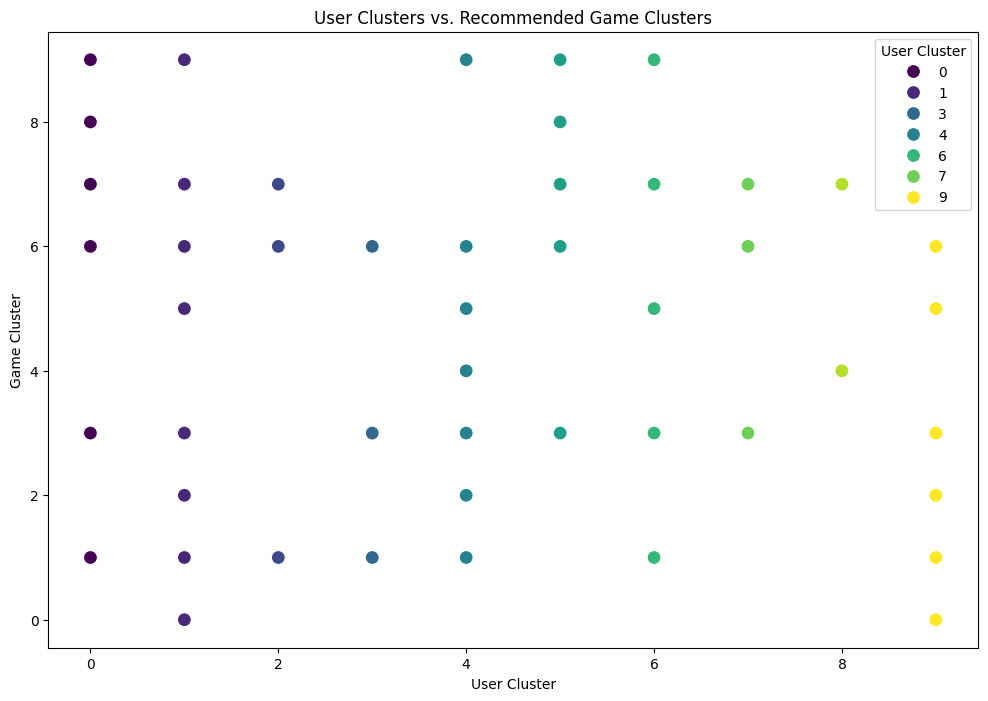

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def visualize_recommendations(recommendations):
    user_ids = []
    user_clusters = []
    game_titles = []
    game_clusters = []

    for user_id, details in recommendations.items():
        user_ids.extend([user_id] * len(details['recommended_games']))
        user_clusters.extend([details['user_cluster']] * len(details['recommended_games']))
        game_titles.extend(details['recommended_games'])
        game_clusters.extend(details['game_clusters'])

    df = pd.DataFrame({
        'User ID': user_ids,
        'User Cluster': user_clusters,
        'Game Title': game_titles,
        'Game Cluster': game_clusters
    })

    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=df, x='User Cluster', y='Game Cluster', hue='User Cluster', palette='viridis', s=100)
    plt.title('User Clusters vs. Recommended Game Clusters')
    plt.xlabel('User Cluster')
    plt.ylabel('Game Cluster')
    plt.legend(title='User Cluster')
    plt.show()

visualize_recommendations(recommendations)
